In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.preprocessing import StandardScaler, RobustScaler, KBinsDiscretizer
from sklearn.metrics import median_absolute_error,r2_score,mean_squared_error
from sklearn import metrics
from sklearn.decomposition import PCA

from sklearn.ensemble import IsolationForest, AdaBoostRegressor, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import ElasticNet,RidgeCV,LassoCV,Ridge,Lasso,LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFE
from sklearn.pipeline import make_pipeline

from scipy.stats import ttest_ind, shapiro
import warnings
warnings.simplefilter("ignore")

In [2]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', -1)

In [3]:
data_2015=pd.read_csv('2015-building-energy-benchmarking.csv')
data_2016=pd.read_csv('2016-building-energy-benchmarking.csv')

In [4]:
data_2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340 entries, 0 to 3339
Data columns (total 47 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   OSEBuildingID                                                  3340 non-null   int64  
 1   DataYear                                                       3340 non-null   int64  
 2   BuildingType                                                   3340 non-null   object 
 3   PrimaryPropertyType                                            3340 non-null   object 
 4   PropertyName                                                   3340 non-null   object 
 5   TaxParcelIdentificationNumber                                  3338 non-null   object 
 6   Location                                                       3340 non-null   object 
 7   CouncilDistrictCode                                         

In [5]:
data_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

### Nettoyage et Tri des features

In [6]:
# En 2016, on voit une colonne de type booléen « Données par défaut », qui en 2015 est représentée comme un type d'objet.
data_2016['DefaultData'] = data_2016['DefaultData'].astype('object')
data_2016['DefaultData'].value_counts()

False    3263
True     113 
Name: DefaultData, dtype: int64

In [7]:
# Les valeurs manquantes en 2015 et 2016
print("Les valeurs manquantes en 2015 :% .2f" %(data_2015.isna().sum()/data_2015.shape[0]).sum())
print("Les valeurs manquantes en 2016 :% .2f" %(data_2016.isna().sum()/data_2016.shape[0]).sum())

Les valeurs manquantes en 2015 : 7.94
Les valeurs manquantes en 2016 : 5.91


In [8]:
(data_2015.isna().sum()/data_2016.shape[0]).sort_values(ascending = False)

Comment                                                          0.985486
Outlier                                                          0.964455
YearsENERGYSTARCertified                                         0.956754
City Council Districts                                           0.926244
2010 Census Tracts                                               0.922986
ThirdLargestPropertyUseTypeGFA                                   0.823460
ThirdLargestPropertyUseType                                      0.823460
SecondLargestPropertyUseTypeGFA                                  0.527547
SecondLargestPropertyUseType                                     0.527547
ENERGYSTARScore                                                  0.231043
LargestPropertyUseTypeGFA                                        0.040284
LargestPropertyUseType                                           0.040284
ListOfAllPropertyUseTypes                                        0.037618
SiteEnergyUse(kBtu)                   

In [9]:
(data_2016.isna().sum()/data_2016.shape[0]).sort_values(ascending = False)

Comments                           1.000000
Outlier                            0.990521
YearsENERGYSTARCertified           0.964751
ThirdLargestPropertyUseType        0.823460
ThirdLargestPropertyUseTypeGFA     0.823460
SecondLargestPropertyUseType       0.502666
SecondLargestPropertyUseTypeGFA    0.502666
ENERGYSTARScore                    0.249704
LargestPropertyUseTypeGFA          0.005924
LargestPropertyUseType             0.005924
ZipCode                            0.004739
SourceEUI(kBtu/sf)                 0.002666
ListOfAllPropertyUseTypes          0.002666
TotalGHGEmissions                  0.002666
GHGEmissionsIntensity              0.002666
NaturalGas(therms)                 0.002666
SourceEUIWN(kBtu/sf)               0.002666
NaturalGas(kBtu)                   0.002666
SteamUse(kBtu)                     0.002666
Electricity(kWh)                   0.002666
Electricity(kBtu)                  0.002666
NumberofBuildings                  0.002370
SiteEUI(kBtu/sf)                

In [10]:
# Observons la colonne "Comment" de 2015 et "Comments" de 2016 , avant de les supprimer 

In [11]:
data_2015['Comment'].unique() 

array([nan,
       'Under construction starting 6/2013 (old building demolished) and ending 9/2016. New Building re-opened 9/2016. Year built changed from 1948 to 2016.',
       "Part of McKinstry's campus, property operates a fabrication and production shop and is conditioned by natural gas overhead radiant unit heaters with no cooling. Learn more at www.mckinstry.com.",
       "One of two office buildings on McKinstry's campus partially remodeled in 2009 from warehouse to office space. Served by rooftop air handling units with underfloor VAVs.  Self-performed energy efficiency upgrades in 2015 include a long-term LED lighting re",
       'Part of McKinstry’s campus, this remodeled warehouse is mainly office but includes a full-size basketball court and gym with locker rooms, bistro with a full kitchen, and data center. Served by rooftop package units for heating and cooling. Upgrades inclu',
       'Construction completed in mid 2015. The building was unoccupied for most of 2015.',
 

In [12]:
print(data_2015['Comment'].nunique())  # on a 13 lignes remplis 
data_2015[data_2015['Comment'].notna()][['OSEBuildingID','SiteEnergyUse(kBtu)']] # propriété avec ID unique avec sa consommation d'énergies en 2015


13


,OSEBuildingID,SiteEnergyUse(kBtu)
62,87,NaN
436,594,2227640.0
437,595,1998767.0
595,792,6102883.0
719,19694,NaN
1358,21570,NaN
1360,21578,NaN
1373,21616,2255905.0
2108,24408,NaN
2230,24780,3293119.0


####  Une partie est en construction, une autre partie a déjà repris l'activités. En 2015 et 2016, une seule entreprise  était en construction. En tout cas, on peut même la lasser sans toucher  car en combinant ces 2 dataframes, la moyenne sera toujours "zero" Mais, en revanche, nous sommes obligés de retirer à partir de 2015 les entreprises qui ont une consommation « NAN », sinon nous diviserons par 2 la consommation d'energie  pour des  années  prochaines

In [13]:

data_2015[data_2015['Comment'].notna()]['Comment'].str.partition('construction starting ')

,0,1,2
62,Under,construction starting,6/2013 (old building demolished) and ending 9/2016. New Building re-opened 9/2016. Year built changed from 1948 to 2016.
436,"Part of McKinstry's campus, property operates a fabrication and production shop and is conditioned by natural gas overhead radiant unit heaters with no cooling. Learn more at www.mckinstry.com.",,
437,One of two office buildings on McKinstry's campus partially remodeled in 2009 from warehouse to office space. Served by rooftop air handling units with underfloor VAVs. Self-performed energy efficiency upgrades in 2015 include a long-term LED lighting re,,
595,"Part of McKinstry’s campus, this remodeled warehouse is mainly office but includes a full-size basketball court and gym with locker rooms, bistro with a full kitchen, and data center. Served by rooftop package units for heating and cooling. Upgrades inclu",,
719,Construction completed in mid 2015. The building was unoccupied for most of 2015.,,
1358,Under,construction starting,6/2013 (old building demolished) and ending 9/2016. New Building re-opened 9/2016. Year built changed from 1950 to 2016.
1360,Under,construction starting,6/2013 (old building demolished) and ending 9/2016. New Building re-opened 9/2016. Year built changed from 1949 to 2016.
1373,Under,construction starting,6/2015 (old building demolished) and ending 9/2017. New Building re-opens 9/2017. Year built changed from 1954 to 2017.
2108,Under,construction starting,09/2014 (old building demolished) and ending 9/2017. New Buildings (two) re-open 9/2017. Year built changed from 1953 to 2017.
2230,"Part of McKinstry's campus, the office space for this building sites on the 3rd floor above a 2-story parking garage and is served by rooftop package units for both heating and cooling. Learn more at www.mckinstryinnovationcenter.com.",,


In [14]:
data_2016[data_2016['OSEBuildingID'].isin(data_2015[data_2015['Comment'].notna()]['OSEBuildingID'])][['OSEBuildingID','SiteEnergyUse(kBtu)']]

,OSEBuildingID,SiteEnergyUse(kBtu)
62,87,0.000
433,594,2339814.250
434,595,2058955.250
591,792,6235947.000
713,19694,1967476.375
1347,21570,991918.000
1349,21578,2246747.500
1361,21616,0.000
2206,24780,3245111.500
2292,25163,2794837.000


In [15]:
# Recuperation les index les lignes avec "NAN" en colonne 'SiteEnergyUse(kBtu)'
ind_2015_null = data_2015[data_2015['Comment'].notna()]['SiteEnergyUse(kBtu)'][data_2015[data_2015['Comment'].notna()]['SiteEnergyUse(kBtu)'].isna()].index
ind_2015_null

Int64Index([62, 719, 1358, 1360, 2108, 2381], dtype='int64')

In [16]:
# Suppression ces lignes
data_2015.drop(index=ind_2015_null,inplace=True)

In [17]:
# Suppression les colonnes "Comment"  de 2015 et "Comments" de 2016

In [18]:
data_2015.drop(columns='Comment' , inplace=True)
data_2016.drop(columns='Comments' , inplace=True)

### PrimaryPropertyType
##### L'utilisation principale d'une propriété (par exemple, un bureau, un magasin de détail). L'usage                                principal est défini comme une fonction qui représente plus de 50 % d'un bien. Il s'agit du champ Type                          de propriété - EPA calculé de Portfolio Manager.

In [19]:
data_2015['PrimaryPropertyType'].unique()

array(['Hotel', 'Other', 'Mid-Rise Multifamily', 'Mixed Use Property',
       'K-12 School', 'College/University', 'Small- and Mid-Sized Office',
       'Self-Storage Facility\n', 'Distribution Center', 'Large Office',
       'Retail Store', 'Low-Rise Multifamily', 'Senior Care Community',
       'Medical Office', 'Hospital', 'Residence Hall/Dormitory',
       'Non-Refrigerated Warehouse', 'Distribution Center\n',
       'SPS-District K-12', 'Worship Facility',
       'Supermarket/Grocery Store', 'Laboratory', 'Self-Storage Facility',
       'Refrigerated Warehouse', 'High-Rise Multifamily', 'Restaurant\n',
       'Restaurant'], dtype=object)

In [20]:
data_2016['PrimaryPropertyType'].unique()

array(['Hotel', 'Other', 'Mid-Rise Multifamily', 'Mixed Use Property',
       'K-12 School', 'University', 'Small- and Mid-Sized Office',
       'Self-Storage Facility', 'Warehouse', 'Large Office',
       'Senior Care Community', 'Medical Office', 'Retail Store',
       'Hospital', 'Residence Hall', 'Distribution Center',
       'Worship Facility', 'Low-Rise Multifamily',
       'Supermarket / Grocery Store', 'Laboratory',
       'Refrigerated Warehouse', 'Restaurant', 'High-Rise Multifamily',
       'Office'], dtype=object)

In [21]:
data_2015['PrimaryPropertyType'] = data_2015['PrimaryPropertyType'].str.replace('\n','')
data_2016['PrimaryPropertyType'] = data_2016['PrimaryPropertyType'].str.replace('\n','')


### CouncilDistrictCode et City Council Districts
##### Propriété District municipal de la ville de Seattle.

In [22]:
# Observons  ces deux colonnes de 2015 (en 2016 ona que 'CouncilDistrictCode' )
print("CouncilDistrictCode : {: .2f} % valeurs vide".format(data_2015['CouncilDistrictCode'].isna().sum()/data_2015.shape[0]))
print("City Council Districts'data_2015: {: .2f}  %  valeurs vide".format(data_2015['City Council Districts'].isna().sum()/data_2015.shape[0]))
data_2015[['CouncilDistrictCode','City Council Districts']]

CouncilDistrictCode :  0.00 % valeurs vide
City Council Districts'data_2015:  0.94  %  valeurs vide


,CouncilDistrictCode,City Council Districts
0,7,NaN
1,7,NaN
2,7,NaN
3,7,NaN
4,7,NaN
...,...,...
3335,2,NaN
3336,4,NaN
3337,7,NaN
3338,4,NaN


In [23]:
data_2015[data_2015['City Council Districts'].notna()]['CouncilDistrictCode'].value_counts()

5    200
6    11 
4    2  
Name: CouncilDistrictCode, dtype: int64

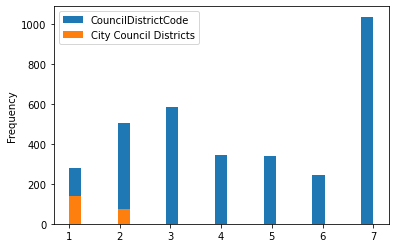

In [24]:
data_2015[['CouncilDistrictCode','City Council Districts']].plot.hist(bins=25)
plt.show()

In [25]:
# On la supprimme
data_2015.drop(columns='City Council Districts', inplace=True)

In [26]:
print(data_2015.shape, data_2016.shape)

(3334, 45) (3376, 45)


### Neighborhood 
##### Zone du quartier de la propriété définie par le département des quartiers de la ville de Seattle.

In [27]:
data_2016[data_2016['OSEBuildingID'] == 16][['OSEBuildingID','ZipCode','Neighborhood','CouncilDistrictCode']]

,OSEBuildingID,ZipCode,Neighborhood,CouncilDistrictCode
11,16,98101.0,DOWNTOWN,7


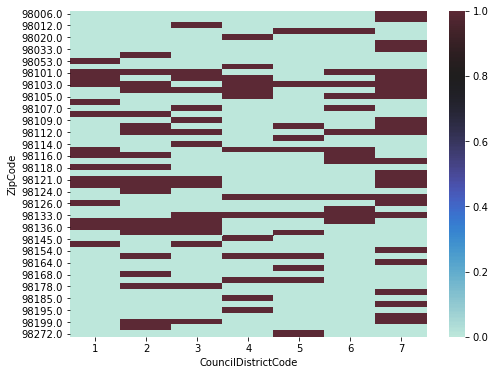

In [28]:
# Pour mieux comprendre nos données on  va croiser les colonnes et lignes  pour ID =16(par exemple )

"""
Pour ID = 16 on a:
                    CouncilDistrictCode =7 
                    Zip Code = 98101
                    Neighborhood = DOWNTOWN correspond à 7 et 2 -> voir le tableau ci-dessus 
"""
plt.figure(figsize=(8,6))
sns.heatmap(pd.crosstab(data_2016['ZipCode'], data_2016['CouncilDistrictCode']),vmax=1,vmin=0,center=0.8)
plt.show()

In [29]:
# Tant que les quartiers portent les infos plus détaillées que les zones géographiques,donc on va les garder

In [30]:
print(data_2015['Neighborhood'].isna().sum(),data_2016['Neighborhood'].isna().sum() )# Verif valeurs manquants

0 0


In [31]:
data_2015.Neighborhood.value_counts()

DOWNTOWN                 578
EAST                     444
MAGNOLIA / QUEEN ANNE    420
GREATER DUWAMISH         369
NORTHEAST                258
LAKE UNION               249
NORTHWEST                225
NORTH                    187
SOUTHWEST                163
CENTRAL                  130
BALLARD                  130
SOUTHEAST                96 
DELRIDGE                 85 
Name: Neighborhood, dtype: int64

In [32]:
data_2016[['ZipCode','Neighborhood']].value_counts()

ZipCode  Neighborhood         
98104.0  DOWNTOWN                 183
98105.0  NORTHEAST                182
98134.0  GREATER DUWAMISH         182
98109.0  MAGNOLIA / QUEEN ANNE    178
98121.0  DOWNTOWN                 178
98101.0  DOWNTOWN                 178
98122.0  EAST                     171
98119.0  MAGNOLIA / QUEEN ANNE    165
98108.0  GREATER DUWAMISH         121
98102.0  EAST                     120
98133.0  NORTHWEST                120
98109.0  LAKE UNION               108
98125.0  NORTH                    102
98116.0  SOUTHWEST                91 
98107.0  BALLARD                  91 
98103.0  LAKE UNION               88 
98115.0  NORTHEAST                74 
98199.0  MAGNOLIA / QUEEN ANNE    67 
98118.0  SOUTHEAST                61 
98122.0  CENTRAL                  60 
98104.0  EAST                     60 
98103.0  NORTHWEST                56 
98101.0  EAST                     49 
98106.0  DELRIDGE                 45 
98112.0  EAST                     42 
98125.0  North     

In [33]:
data_2015['Neighborhood'].unique()

array(['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST', 'CENTRAL', 'NORTH',
       'MAGNOLIA / QUEEN ANNE', 'LAKE UNION', 'GREATER DUWAMISH',
       'BALLARD', 'NORTHWEST', 'SOUTHWEST', 'DELRIDGE'], dtype=object)

In [34]:
data_2016['Neighborhood'].unique()

array(['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST', 'Central', 'NORTH',
       'MAGNOLIA / QUEEN ANNE', 'LAKE UNION', 'GREATER DUWAMISH',
       'BALLARD', 'NORTHWEST', 'CENTRAL', 'SOUTHWEST', 'DELRIDGE',
       'Ballard', 'North', 'Delridge', 'Northwest',
       'DELRIDGE NEIGHBORHOODS'], dtype=object)

In [35]:
data_2015['Neighborhood'] = data_2015['Neighborhood'].str.capitalize().astype('category') # transform en type cat
data_2016['Neighborhood'] = data_2016['Neighborhood'].str.capitalize().astype('category') # transform en type cat

In [36]:
# One hot apres l'assemlage

In [37]:
# Suppresion les colonnes qui ne sont plus utiles pour nous
data_2015.drop(columns=['Location','CouncilDistrictCode'], inplace=True)
data_2016.drop(columns=['ZipCode','CouncilDistrictCode'], inplace=True)

#### Préparation assemblage des 2 dataframes

In [38]:
def compare_colums(df1,df2):
    columns_1 = list(df1.columns) 
    columns_2 = list(df2.columns)
    same_columns=[]
    diff_columns_2=[]
    diff_columns_1=[]

    for col in columns_2:
        if col in columns_1:
            same_columns.append(col)
        else:
            diff_columns_2.append(col)
    for col in columns_1:
        if col not in columns_2:
            diff_columns_1.append(col)
    print('colonnes présentes sur données 2015 et absentes sur 2016 : \n', diff_columns_1)
    print('\ncolonnes présentes sur données 2016 et absentes sur 2015 : \n', diff_columns_2)
    return None
    

In [39]:
compare_colums(data_2015,data_2016)

colonnes présentes sur données 2015 et absentes sur 2016 : 
 ['OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)', '2010 Census Tracts', 'Seattle Police Department Micro Community Policing Plan Areas', 'SPD Beats', 'Zip Codes']

colonnes présentes sur données 2016 et absentes sur 2015 : 
 ['Address', 'City', 'State', 'Latitude', 'Longitude', 'TotalGHGEmissions', 'GHGEmissionsIntensity']


In [40]:
data_2016.drop(columns=['Address', 'City', 'State', 'Latitude', 'Longitude'], inplace=True)
data_2015.drop(columns=['2010 Census Tracts', 'Seattle Police Department Micro Community Policing Plan Areas', 'SPD Beats', 'Zip Codes'],inplace=True)

In [41]:
# Voici la liste des propriétés, qui utilisés 'OtherFuelUse(kBtu)' en 2015. 
other_fuel_2015 = data_2015[data_2015['OtherFuelUse(kBtu)'] !=0.0]['OSEBuildingID']
other_fuel_2015

69      103  
70      104  
71      106  
73      110  
75      112  
270     398  
331     466  
374     523  
451     609  
578     772  
767     19798
1291    21436
1301    21464
1302    21465
1346    21548
1838    23508
2152    24547
2283    25004
2406    25451
2818    26938
3221    49725
Name: OSEBuildingID, dtype: int64

#### On voit qu'en 2016, les entreprises continuent de fonctionner, mais cette colonne a été supprimée.
#### nous obtiendrons les valeurs puis les ajouterons à la colonne SteamUse (kBtu)

In [42]:

data_2016[data_2016['OSEBuildingID'].isin(other_fuel_2015)]['OSEBuildingID']

69      103  
70      104  
71      106  
73      110  
75      112  
270     398  
329     466  
371     523  
449     609  
577     772  
758     19798
1280    21436
1291    21464
1292    21465
1336    21548
1819    23508
2129    24547
2257    25004
2379    25451
3182    49725
Name: OSEBuildingID, dtype: int64

In [43]:
for i in data_2015[data_2015['OSEBuildingID'].isin(other_fuel_2015)]['OSEBuildingID'].index:
    data_2015.loc[i,'SteamUse(kBtu)'] +=data_2015.loc[i,'OtherFuelUse(kBtu)']

In [44]:
# Suppression 
data_2015.drop(columns=['OtherFuelUse(kBtu)'], inplace=True)

In [45]:
# En 2016 ils ont renommée encore deux features. On va mettre a jour
data_2015.rename(columns={'GHGEmissions(MetricTonsCO2e)': 'TotalGHGEmissions','GHGEmissionsIntensity(kgCO2e/ft2)':'GHGEmissionsIntensity'},inplace=True)

In [46]:
# Verification 
def diff_liste(liste_1,liste_2):
    dif_col_list1_list2 = set(liste_1) - set(liste_2)
    if dif_col_list1_list2 == set():
        print("toutes les colonnes sont identiques \n")
    else:
        print('Les colonnes sont en list1 mais pas en list2 : \n',dif_col_list1_list2, '\n' )
    
    dif_col_list2_list1 = set(liste_2) - set(liste_1)
    if dif_col_list2_list1 == set():
        print("toutes les colonnes sont identiques \n")
    else:
        print('Les colonnes sont en list2 mais pas en list1  : \n',dif_col_list2_list1 )
    return  list(dif_col_list1_list2), list(dif_col_list2_list1)  

In [47]:
a,b =diff_liste(data_2015.columns,data_2016.columns)

toutes les colonnes sont identiques 

toutes les colonnes sont identiques 



#### Une liste d'entreprises qui ont fermé complètement (soit pour des rénovations) en 2015, et une autre liste d'entreprises qui ont commencé à fonctionner  (soit repris ses activité) en 2016

In [48]:
a,b = diff_liste(data_2015['OSEBuildingID'],data_2016['OSEBuildingID'])

Les colonnes sont en list1 mais pas en list2 : 
 {24194, 24068, 266, 23308, 28045, 400, 25617, 790, 22808, 22172, 28064, 24739, 675, 21796, 23848, 22441, 19882, 22446, 559, 560, 20658, 27699, 21555, 27829, 25654, 20152, 21688, 442, 26938, 27706, 61, 19905, 49859, 19780, 325, 838, 24904, 19656, 714, 19658, 27985, 25042, 27355, 25821, 21471, 25701, 24168, 49769, 19947, 25455, 499, 21237, 27639, 22138, 23163} 

Les colonnes sont en list2 mais pas en list1  : 
 {19456, 50196, 50198, 50201, 50204, 50207, 50208, 50210, 50212, 43, 50220, 50221, 50222, 50223, 50224, 50225, 50226, 49715, 49716, 21570, 21578, 87, 20585, 21103, 29390, 750, 19694, 50219, 25361, 49964, 49967, 49968, 49970, 49972, 49979, 49980, 49983, 49986, 49987, 49988, 49990, 50000, 50003, 50005, 50006, 50011, 50014, 50015, 50017, 24418, 21860, 50021, 50022, 50026, 364, 365, 50030, 50029, 50031, 50035, 50037, 50039, 50044, 50045, 50046, 50047, 50050, 50054, 50056, 50061, 50062, 23437, 50068, 50069, 50070, 50071, 50072, 50074, 500

In [49]:
data_2015[data_2015['OSEBuildingID'].isin(a)]['PropertyName']

47      GATEWOOD APTS                                             
165     WEST SEATTLE COMM. RESOURCE CENTER/FOOD BANK APT/MIXED USE
204     WESTLAKE MALL RETAIL PORTION                              
272     GALLAND & SENECA BUILDINGS                                
312     KING BROADCASTING                                         
358     ASIAN COUNSELING and REFERRAL SERVICE BUILDING            
405     YALE & THOMAS                                             
406     EVERGREEN WHLSLE FLORIST (DEMOLISHED)                     
498     NINTH & JEFFERSON BLDG - HARBORVIEW                       
530     MARITIME BUILDING                                         
593     PROLOGIS SEATTLE 10 (ROSS DISPLAY)                        
627     NORTHWEST MEDICAL CENTER                                  
702     1916 Boren Building                                       
703     DENNY CENTER                                              
756     AURORA CHRYSLER PLYMOUTH                              

In [50]:
# En 2015 ces entreprises consommées d'énergie (en totalité) et émetes du carbone (en totalité)
data_2015[data_2015['OSEBuildingID'].isin(a)][['SiteEnergyUse(kBtu)','TotalGHGEmissions']].sum(axis=0)

SiteEnergyUse(kBtu)    3.499839e+08
TotalGHGEmissions      9.376310e+03
dtype: float64

In [51]:
# En 2016 ces entreprises consommées d'énergie (en totalité) et émetes du carbone (en totalité)
data_2016[data_2016['OSEBuildingID'].isin(b)][['SiteEnergyUse(kBtu)','TotalGHGEmissions']].sum(axis=0)


SiteEnergyUse(kBtu)    1.849767e+09
TotalGHGEmissions      3.862233e+04
dtype: float64

In [52]:
ratio_energie_depart_arrivee = (data_2016[data_2016['OSEBuildingID'].isin(b)]['SiteEnergyUse(kBtu)'].sum(axis=0))/(data_2015[data_2015['OSEBuildingID'].isin(a)]['SiteEnergyUse(kBtu)'].sum(axis=0))
ratio_CO2_depart_arrivee = (data_2016[data_2016['OSEBuildingID'].isin(b)]['TotalGHGEmissions'].sum(axis=0))/(data_2015[data_2015['OSEBuildingID'].isin(a)]['TotalGHGEmissions'].sum(axis=0))
print("Ratio_CO2_depart_arrivee : %.2f" % ratio_CO2_depart_arrivee)
print("Ratio_energie_depart_arrivee : %.2f" % ratio_energie_depart_arrivee)

Ratio_CO2_depart_arrivee : 4.12
Ratio_energie_depart_arrivee : 5.29


### YearBuilt
##### Année au cours de laquelle une propriété a été construite ou a subi une rénovation complète.

In [53]:
print(data_2015['YearBuilt'].min(),data_2016['YearBuilt'].min()) # l'année des premieres constructions
print(data_2015['YearBuilt'].max(),data_2016['YearBuilt'].max()) # l'année des dernières  constructions

1900 1900
2015 2015


### NumberofBuildings
##### Nombre de bâtiments inclus dans le rapport de la propriété. Dans les cas où une propriété est déclarée comme un campus,        plusieurs bâtiments peuvent être inclus dans un seul rapport.

In [54]:
# Observation ces valeurs (il y une propriété atypique )
data_2015['NumberofBuildings'].value_counts()

1     3315
2     5   
7     3   
3     3   
6     3   
39    1   
11    1   
16    1   
10    1   
4     1   
Name: NumberofBuildings, dtype: int64

In [55]:
data_2015[data_2015['NumberofBuildings'] == 39]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,DefaultData,ComplianceStatus,Outlier
1508,22062,2015,Campus,College/University,SEATTLE UNIVERSITY (MAIN CAMPUS),2254500880,East,1939,39,2.0,2200000,0,2200000,"College/University, Parking",College/University,1719643.0,Parking,318960.0,NaN,NaN,NaN,NaN,66.9,76.4,146.1,158.3,115080128.0,131427232.0,0.0,18292370.0,62416157.0,526666.0,52666569.0,3232.23,1.35,No,Compliant,NaN


In [56]:
# En 2016 . 
# Observons 3 choses :
#  * 1.la valeur = 0.0
#  * 2.on n'a plus la propriété avec nombre de bâtiments egal à 39 (trouvé en 2015)
#  * 3.on un autre bâtiment avec le nombre 111

data_2016['NumberofBuildings'].value_counts()

1.0      3175
0.0      92  
2.0      37  
3.0      22  
4.0      12  
5.0      10  
6.0      5   
8.0      3   
14.0     2   
10.0     2   
9.0      2   
11.0     1   
27.0     1   
7.0      1   
16.0     1   
23.0     1   
111.0    1   
Name: NumberofBuildings, dtype: int64

In [57]:
# point N1 
# Recuperation de numero ID en 2016, pour chercher et remplacer les données a partir de 2015
pas_de_bat=data_2016[data_2016['NumberofBuildings'] == 0]['OSEBuildingID'].values
pas_de_bat

array([   89,   113,   257,   322,   366,   391,   408,   410,   421,
         504,   517,   576,   588,   594,   640,   649,   657,   673,
         735,   812, 19533, 19741, 19835, 19900, 19969, 20186, 20323,
       20403, 20427, 20474, 20532, 20543, 20630, 21180, 21240, 21285,
       21295, 21336, 21365, 21508, 21659, 21662, 21811, 22512, 22801,
       23909, 24069, 24270, 24514, 24556, 24646, 24689, 24716, 24822,
       24989, 25028, 25047, 25144, 25242, 25386, 25461, 25542, 25546,
       25661, 25696, 25772, 25866, 25902, 25997, 26119, 26331, 26357,
       26706, 26719, 26833, 26924, 27232, 27591, 27673, 27734, 27996,
       28008, 32454, 33289, 36034, 42067, 45287, 49729, 49779, 49783,
       49862, 49924], dtype=int64)

In [58]:
# Donc on peut les remplacer et mettre 1.0
data_2015[data_2015['OSEBuildingID'].isin(pas_de_bat)]['NumberofBuildings'].value_counts()

1    92
Name: NumberofBuildings, dtype: int64

In [59]:
data_2016['NumberofBuildings'].replace({0.0 : 1.0}, inplace=True)

In [60]:
# point N2
data_2016[data_2016['OSEBuildingID'] == 22062]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
1494,22062,2016,Campus,University,Entire Campus,2254500880,East,1939,1.0,2,2200000,0,2200000,"College/University, Parking",College/University,1719643.0,Parking,318960.0,NaN,NaN,NaN,NaN,66.699997,71.599998,145.0,151.300003,114648520.0,123205560.0,0.0,18075270.0,61672821.0,529756.9375,52975694.0,False,Compliant,NaN,3243.48,1.47


In [61]:
# Tant que ils occupe la même surface en 2015 et 2016 , donc on sera obligé de remettre la valeur 39
print(data_2015[data_2015['OSEBuildingID'] == 22062]['LargestPropertyUseTypeGFA'])
print(data_2016[data_2016['OSEBuildingID'] == 22062]['LargestPropertyUseTypeGFA'])

1508    1719643.0
Name: LargestPropertyUseTypeGFA, dtype: float64
1494    1719643.0
Name: LargestPropertyUseTypeGFA, dtype: float64


In [62]:
data_2016.loc[data_2016['OSEBuildingID'] == 22062,['NumberofBuildings']] = 39 # attribution de la valeur

In [63]:
data_2016['NumberofBuildings'].value_counts() # verif de résultats

1.0      3266
2.0      37  
3.0      22  
4.0      12  
5.0      10  
6.0      5   
8.0      3   
14.0     2   
9.0      2   
10.0     2   
39.0     1   
11.0     1   
7.0      1   
27.0     1   
16.0     1   
23.0     1   
111.0    1   
Name: NumberofBuildings, dtype: int64

In [64]:
# Détection des anomalies identiques 

data_2016[data_2016['BuildingType']=='Campus'][data_2016[data_2016['BuildingType']=='Campus']['NumberofBuildings'] ==1.0]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
35,43,2016,Campus,Mixed Use Property,Plant 2 Site,0022000005,Greater duwamish,1992,1.0,3,494835,0,494835,"Energy/Power Station, Laboratory, Manufacturing/Industrial Plant, Non-Refrigerated Warehouse, Office",Office,757027.0,Laboratory,639931.0,Non-Refrigerated Warehouse,459748.0,NaN,8.0,221.699997,233.100006,388.200012,400.299988,4.483853e+08,4.716139e+08,0.0000,4.410208e+07,150476283.0,2.979090e+06,297909000.0,False,Compliant,NaN,16870.98,34.09
289,419,2016,Campus,Mixed Use Property,Main Market,1976200205,Downtown,1908,1.0,4,137400,0,137400,"Food Sales, Multifamily Housing, Office, Other - Education, Other - Restaurant/Bar, Pre-school/Daycare, Restaurant, Retail Store, Supermarket/Grocery Store",Retail Store,44078.0,Other - Restaurant/Bar,19182.0,Multifamily Housing,14380.0,NaN,NaN,122.800003,122.300003,306.600006,305.000000,1.494050e+07,1.487976e+07,0.0000,3.031867e+06,10344729.0,4.595774e+04,4595774.0,False,Compliant,NaN,316.20,2.30
340,477,2016,Campus,Other,Weintraub/Hutchinson/Thomas,1984200455,Lake union,1997,1.0,5,535947,0,535947,"Other, Parking",Other,535947.0,Parking,103983.0,NaN,NaN,NaN,NaN,245.100006,255.800003,509.399994,515.599976,1.313739e+08,1.371061e+08,0.0000,1.894122e+07,64627449.0,6.674642e+05,66746425.0,False,Compliant,NaN,3995.45,7.45
1297,21478,2016,Campus,Mixed Use Property,Economy Market,1976200105,Downtown,1900,1.0,2,49280,0,49280,"Food Sales, Office, Restaurant, Retail Store, Self-Storage Facility, Social/Meeting Hall",Retail Store,15614.0,Restaurant,9240.0,Social/Meeting Hall,8199.0,NaN,NaN,110.300003,111.000000,290.899994,293.000000,5.437110e+06,5.469794e+06,0.0000,1.209993e+06,4128496.0,1.308614e+04,1308614.0,False,Compliant,NaN,98.28,1.99
1300,21481,2016,Campus,Low-Rise Multifamily,Sanitary Market,1976200210,Downtown,1942,1.0,4,45500,0,45500,"Bar/Nightclub, Food Sales, Multifamily Housing, Restaurant, Retail Store, Self-Storage Facility",Multifamily Housing,22669.0,Retail Store,10455.0,Restaurant,3668.0,NaN,NaN,85.199997,85.199997,267.500000,267.500000,3.778355e+06,3.778355e+06,0.0000,1.107372e+06,3778355.0,0.000000e+00,0.0,False,Compliant,NaN,26.34,0.58
1301,21482,2016,Campus,Restaurant,Corner Market,1976200230,Downtown,1912,1.0,2,25380,0,25380,"Food Sales, Office, Restaurant",Restaurant,17114.0,Food Sales,6426.0,Office,1840.0,NaN,NaN,271.899994,270.600006,549.200012,545.200012,6.901554e+06,6.868712e+06,0.0000,9.385338e+05,3202277.0,3.699277e+04,3699277.0,False,Compliant,NaN,218.79,8.62
2270,25069,2016,Campus,K-12 School,O'Dea High School,5392100055,East,1923,1.0,4,46100,0,46100,"K-12 School, Parking",K-12 School,46100.0,Parking,0.0,NaN,NaN,NaN,75.0,47.200001,52.299999,101.199997,106.800003,2.177065e+06,2.412536e+06,548294.6875,3.216685e+05,1097533.0,5.312370e+03,531237.0,False,Compliant,NaN,78.19,1.70
2993,27799,2016,Campus,K-12 School,The Bush School - Lower / Middle School,6600000120,Central,1950,1.0,1,109794,0,109794,K-12 School,K-12 School,109794.0,NaN,NaN,NaN,NaN,NaN,87.0,30.000000,33.299999,56.200001,59.599998,3.296526e+06,3.657784e+06,0.0000,3.794745e+05,1294767.0,2.001759e+04,2001759.0,False,Compliant,NaN,115.34,1.05
3022,27901,2016,Campus,K-12 School,The Bush School - Upper School,6600000385,Central,2000,1.0,2,30562,0,30562,K-12 School,K-12 School,30562.0,NaN,NaN,NaN,N

In [65]:
campus_batim_egal_1 = data_2016[data_2016['BuildingType']=='Campus'][data_2016[data_2016['BuildingType']=='Campus']['NumberofBuildings'] ==1.0]['OSEBuildingID']
campus_batim_egal_1

35      43   
289     419  
340     477  
1297    21478
1300    21481
1301    21482
2270    25069
2993    27799
3022    27901
Name: OSEBuildingID, dtype: int64

In [66]:
# Comparaison avec 2015 (il y a une erreur)
data_2015[data_2015['OSEBuildingID'].isin(campus_batim_egal_1)]['NumberofBuildings']

290     1
341     3
1308    1
1311    1
1312    1
2297    1
3031    1
3061    1
Name: NumberofBuildings, dtype: int64

# Valeurs atypiques 

#### On ne peut pas les supprimer, parce que ils consomment beaucoup  d'enrgie, mais on  peut les diviser par  leur nombre de bâtiments 

In [67]:
data_2016[data_2016['NumberofBuildings'] >= 10].head(5)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
105,172,2016,Campus,University,SSCC MAIN CAMPUS,6171900005,Delridge,1970,27.0,2,441071,0,441071,College/University,College/University,483000.0,NaN,NaN,NaN,NaN,NaN,NaN,79.300003,85.199997,192.800003,202.600006,38301744.0,4.115173e+07,0.0,7.419278e+06,25314575.0,129871.66410,12987166.0,False,Compliant,NaN,866.23,1.96
128,211,2016,Campus,University,NSCC MAIN CAMPUS,3226049021,Northwest,1970,11.0,2,694072,111625,582447,College/University,College/University,667335.0,NaN,NaN,NaN,NaN,NaN,NaN,53.799999,56.099998,161.199997,167.000000,35891484.0,3.741080e+07,0.0,9.803878e+06,33450832.0,24406.47852,2440648.0,False,Compliant,NaN,362.82,0.52
162,261,2016,Campus,Large Office,South Park,7883608601,Greater duwamish,1980,14.0,2,334368,31874,302494,"Laboratory, Non-Refrigerated Warehouse, Office, Other - Utility",Office,240984.0,Laboratory,72963.0,Other - Utility,16766.0,NaN,NaN,159.899994,161.899994,451.200012,453.299988,53466684.0,5.413607e+07,0.0,1.328294e+07,45321378.0,81453.00000,8145300.0,False,Compliant,NaN,748.55,2.24
1193,21215,2016,Multifamily LR (1-4),Low-Rise Multifamily,Northline Apartments,1926049216,Northwest,1978,16.0,3,89068,0,89068,"Multifamily Housing, Parking",Multifamily Housing,74125.0,Parking,6325.0,NaN,NaN,NaN,38.0,40.200001,42.599998,126.199997,133.699997,2980240.5,3.155556e+06,0.0,8.734584e+05,2980240.0,0.00000,0.0,False,Compliant,NaN,20.78,0.23
1494,22062,2016,Campus,University,Entire Campus,2254500880,East,1939,39.0,2,2200000,0,2200000,"College/University, Parking",College/University,1719643.0,Parking,318960.0,NaN,NaN,NaN,NaN,66.699997,71.599998,145.000000,151.300003,114648520.0,1.232056e+08,0.0,1.807527e+07,61672821.0,529756.93750,52975694.0,False,Compliant,NaN,3243.48,1.47


In [68]:
# transformation de type
data_2015[['OSEBuildingID','DataYear','YearBuilt']] = data_2015[['OSEBuildingID','DataYear','YearBuilt']].astype('category')
data_2016[['OSEBuildingID','DataYear','YearBuilt']] = data_2016[['OSEBuildingID','DataYear','YearBuilt']].astype('category')

type_num = ['float','int64']

In [69]:
data_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 38 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   OSEBuildingID                    3376 non-null   category
 1   DataYear                         3376 non-null   category
 2   BuildingType                     3376 non-null   object  
 3   PrimaryPropertyType              3376 non-null   object  
 4   PropertyName                     3376 non-null   object  
 5   TaxParcelIdentificationNumber    3376 non-null   object  
 6   Neighborhood                     3376 non-null   category
 7   YearBuilt                        3376 non-null   category
 8   NumberofBuildings                3368 non-null   float64 
 9   NumberofFloors                   3376 non-null   int64   
 10  PropertyGFATotal                 3376 non-null   int64   
 11  PropertyGFAParking               3376 non-null   int64   
 12  Proper

In [70]:
def val_atypique(df,nombre = 10):
    ligne_atypiques =  df[df['NumberofBuildings'] >= nombre].index
    df_num = df.select_dtypes(type_num)
    for i in ligne_atypiques:
        df_num.loc[i,:]/= df.loc[i,'NumberofBuildings'] # division par le nombre de bâtiments 
        
    df_num = pd.concat([df_num,df['OSEBuildingID']], axis=1) # rajoute la colonne 'OSEBuildingID'
    df = pd.merge(df,df_num, on='OSEBuildingID', how = 'right') # attribution de nouvelles valeurs
    suff_x  = [x for x in df.columns if '_x' in x] # la liste des colonnes avec une suffixe _x
    df.drop(columns=suff_x, inplace=True) # suppression   
    df.columns = df.columns.str.replace('_y','') # recuperation les noms des anciennes colonnes 
    return df

In [71]:
data_2015 = val_atypique(data_2015,15)
data_2016 = val_atypique(data_2016,15)

In [72]:
# Verif les résultats pour 2015 et 2016
data_2015[data_2015['NumberofBuildings'] >= 10]['NumberofBuildings']

126     11.0
2011    10.0
Name: NumberofBuildings, dtype: float64

In [73]:
data_2016[data_2016['NumberofBuildings'] >= 10]['NumberofBuildings']

128     11.0
162     14.0
1993    10.0
2318    10.0
2325    14.0
Name: NumberofBuildings, dtype: float64

In [74]:
data_2015['YearBuilt'] = data_2015['YearBuilt'].astype('int64')
data_2016['YearBuilt'] = data_2016['YearBuilt'].astype('int64')

### PropertyGFATotal
##### Superficie totale du bâtiment et du stationnement.

In [75]:
# Verif valeurs négatives
data_2015['PropertyGFATotal'].min()

20000.0

In [76]:
# Une formule pour calculer le troisième composant, si on connaît 2 autres 
(data_2015['PropertyGFATotal'] == data_2015['PropertyGFAParking']+data_2015['PropertyGFABuilding(s)']).value_counts()

True    3334
dtype: int64

In [77]:
# Pas de valeurs manquants 
data_2015[['PropertyGFATotal','PropertyGFAParking','PropertyGFABuilding(s)']].isna().sum(axis=0)

PropertyGFATotal          0
PropertyGFAParking        0
PropertyGFABuilding(s)    0
dtype: int64

In [78]:
# Regardons nos données pour être sûr que n'a pas des valeurs négatives  en 2015
for i in data_2015[['PropertyGFATotal','PropertyGFAParking','PropertyGFABuilding(s)',\
'LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA',
           'ThirdLargestPropertyUseTypeGFA']]:
    print(f'{i:-<35},{data_2015[i].min(axis=0)}')

PropertyGFATotal-------------------,20000.0
PropertyGFAParking-----------------,-3.0
PropertyGFABuilding(s)-------------,-50550.0
LargestPropertyUseTypeGFA----------,5872.0
SecondLargestPropertyUseTypeGFA----,0.0
ThirdLargestPropertyUseTypeGFA-----,0.0


In [79]:
# la colonne 'PropertyGFAParking' a 2 valeurs négatives
data_2015[(data_2015['PropertyGFAParking'] <0)|(data_2015['PropertyGFABuilding(s)'] <0)][['PropertyGFATotal' ,\
                                               'PropertyGFABuilding(s)','PropertyGFAParking','LargestPropertyUseTypeGFA',\
                                                'LargestPropertyUseType','SecondLargestPropertyUseType',\
                                                'ThirdLargestPropertyUseType','OSEBuildingID']]

,PropertyGFATotal,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,OSEBuildingID
2422,20967.0,20970.0,-3.0,20967.0,Multifamily Housing,NaN,NaN,25530
3130,68452.0,68454.0,-2.0,61665.0,Office,Bank Branch,NaN,29551
3133,54015.0,-43310.0,97325.0,54015.0,Office,NaN,NaN,29788
3316,33648.0,-50550.0,84198.0,83600.0,Parking,Automobile Dealership,NaN,50002


In [80]:
# En 2016 on n'a pas les cas pareilles. Donc observons la correction d'auteur de ces dataframes 
data_2016[(data_2016['PropertyGFAParking'] <0)|(data_2016['PropertyGFABuilding(s)'] <0)][['PropertyGFATotal' ,\
                                               'PropertyGFABuilding(s)','PropertyGFAParking','LargestPropertyUseTypeGFA',\
                                                'LargestPropertyUseType','SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType' ]]

,PropertyGFATotal,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType


In [81]:
idn_val_negative = data_2015[(data_2015['PropertyGFAParking'] <0)|(data_2015['PropertyGFABuilding(s)'] <0)]['OSEBuildingID']


In [82]:
data_2016[data_2016['OSEBuildingID'].isin(idn_val_negative)][['PropertyGFATotal' ,\
                                               'PropertyGFABuilding(s)','PropertyGFAParking']]

,PropertyGFATotal,PropertyGFABuilding(s),PropertyGFAParking
2400,20967.0,20967.0,0.0
3095,68452.0,68452.0,0.0
3098,54015.0,54015.0,0.0
3294,33648.0,33648.0,0.0


In [83]:
for i in idn_val_negative:
    data_2015.loc[data_2015['OSEBuildingID'] == i,'PropertyGFAParking'] = 0.0
    data_2015.loc[data_2015['OSEBuildingID'] == i,'PropertyGFABuilding(s)'] =\
    data_2015.loc[data_2015['OSEBuildingID'] == i,'PropertyGFATotal']

In [84]:
data_2015[(data_2015['PropertyGFAParking'] <0)|(data_2015['PropertyGFABuilding(s)'] <0)][['PropertyGFATotal' ,\
                                               'PropertyGFABuilding(s)','PropertyGFAParking','LargestPropertyUseTypeGFA',\
                                                'LargestPropertyUseType','SecondLargestPropertyUseType',\
                                                'ThirdLargestPropertyUseType','OSEBuildingID']]

,PropertyGFATotal,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,OSEBuildingID


### YearsENERGYSTARCertified
#### Si votre bâtiment a reçu une cote ENERGY STAR de 75 ou plus, il peut être admissible à la certification ENERGY STAR
##### Années où la propriété a reçu la certification ENERGY STAR.

In [85]:
data_2015[data_2015['YearsENERGYSTARCertified'].notna()]['YearsENERGYSTARCertified']

36      2016                                                                                    
43      2016                                                                                    
53      2014                                                                                    
115     2016                                                                                    
135     2016                                                                                    
204     2012                                                                                    
206     2015                                                                                    
207     2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008                                    
209     2010, 2009, 2007                                                                        
211     2010, 2007                                                                              
212     2016, 2015            

#### La propriété a un certificat - 10 points. 5 points - ils l'avaient, mais pas maintenant. 0 point - jamais eu

In [86]:
for ind in data_2015[data_2015['YearsENERGYSTARCertified'].str.contains('2016|2015|2014') == True].index:
    data_2015.loc[ind,'YearsENERGYSTARCertified'] = 10
for ind in data_2016[data_2016['YearsENERGYSTARCertified'].str.contains('2017|2016|2015') == True].index:
    data_2016.loc[ind,'YearsENERGYSTARCertified'] = 10    

In [87]:
for ind in data_2015[data_2015['YearsENERGYSTARCertified'].str.contains('2016|2015|2014') == False].index:
    data_2015.loc[ind,'YearsENERGYSTARCertified'] = 5
for ind in data_2016[data_2016['YearsENERGYSTARCertified'].str.contains('2017|2016|2015') == False].index:
    data_2016.loc[ind,'YearsENERGYSTARCertified'] = 5

In [88]:

data_2015['YearsENERGYSTARCertified'].fillna(0.0, inplace=True)
data_2016['YearsENERGYSTARCertified'].fillna(0.0, inplace=True)

In [89]:
print(data_2015['YearsENERGYSTARCertified'].isna().sum())
data_2016['YearsENERGYSTARCertified'].isna().sum()

0


0

In [90]:
data_2016['YearsENERGYSTARCertified'].dtype

dtype('float64')

### ENERGYSTARScore
##### Une note de 1 à 100 calculée par l'EPA évalue la performance énergétique globale d'une propriété, sur la base de données        nationales pour contrôler les différences entre le climat, les utilisations du bâtiment et les opérations. Un score de          50 représente la médiane nationale.

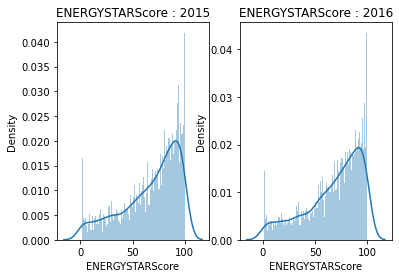

In [91]:
plt.subplot(121)
plt.title("ENERGYSTARScore : 2015")
sns.distplot(data_2015['ENERGYSTARScore'],bins=100)
plt.subplot(122)
plt.title("ENERGYSTARScore : 2016")
sns.distplot(data_2016['ENERGYSTARScore'],bins=100)
plt.show()

#### Il s'exprime sur une échelle simple de 1 à 100, et plus le score est élevé, plus l'efficacité énergétique du bâtiment est élevée.

##### Nous verrons la différence entre la moyenne et la médiane. Si c'est grand, alors Seattle est basé sur certaines  entreprise.

In [92]:
print("Différance   mediane= {:.2f}  et mean= {:.2f} en 2015 ".format(data_2015['ENERGYSTARScore'].median(),data_2015['ENERGYSTARScore'].mean()))
print("Différance   mediane= {:.2f}  et mean= {:.2f} en 2016 ".format(data_2016['ENERGYSTARScore'].median(),data_2016['ENERGYSTARScore'].mean()))

Différance   mediane= 76.00  et mean= 67.89 en 2015 
Différance   mediane= 75.00  et mean= 67.90 en 2016 


In [93]:
# La proportion (presque 40% d'entreprise se trouvent au-dessus de médiane  en 2015)

(data_2015['ENERGYSTARScore']>=76).value_counts(normalize=True)

False    0.614277
True     0.385723
Name: ENERGYSTARScore, dtype: float64

In [94]:
# Idem pour 2016
(data_2016['ENERGYSTARScore']>=75).value_counts(normalize=True)

False    0.616114
True     0.383886
Name: ENERGYSTARScore, dtype: float64

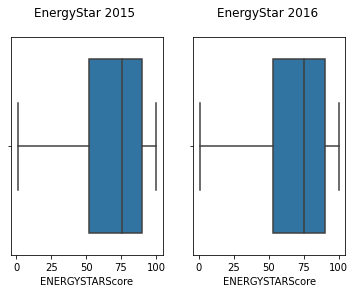

In [95]:
# Représentation graphique qui prouve nos 
plt.figure()
plt.subplot(121)
plt.title('EnergyStar 2015 \n');
sns.boxplot(data_2015['ENERGYSTARScore']);
plt.subplot(122)
plt.title('EnergyStar 2016 \n');
sns.boxplot(data_2016['ENERGYSTARScore'])
plt.show()

In [96]:
"""
De nombreuses valeurs "ENERGY STAR Score" ne sont pas renseignées. 
C'est peut-être aussi l'une des raisons pour lesquelles nous avons un gross écart .
"""
print("Valeurs manquant en 2015: {:.2g} %".format(data_2015['ENERGYSTARScore'].isna().sum()*100/data_2015.shape[0]))
print("Valeurs manquant en 2016: {:.2g} %".format(data_2016['ENERGYSTARScore'].isna().sum()*100/data_2016.shape[0]))

Valeurs manquant en 2015: 23 %
Valeurs manquant en 2016: 25 %


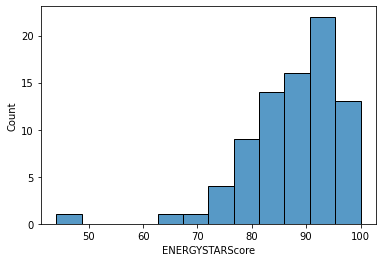

In [97]:
# C"est logique d'avoir au même temps et le certificat et le score plus que 75%
sns.histplot(data_2015[data_2015['YearsENERGYSTARCertified'] == 10]['ENERGYSTARScore'])
plt.savefig('image/YearsENERGYSTARCertified_1.png')

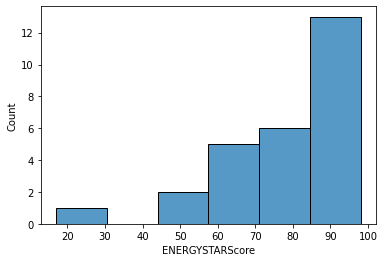

In [98]:
# Mais avoir le score plus de 75% et de ne fait pas la démarche  pour avoir le certif... Complètement bizarre !!!
sns.histplot(data_2015[data_2015['YearsENERGYSTARCertified'] == 5.0]['ENERGYSTARScore'])
plt.savefig('image/YearsENERGYSTARCertified_2.png')

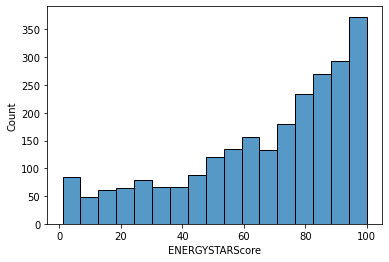

In [99]:
# Observons les entreprises qui n'ont jamais eu de certificat
sns.histplot(data_2015[data_2015['YearsENERGYSTARCertified'] ==0.0]['ENERGYSTARScore'])
plt.savefig('image/YearsENERGYSTARCertified_3.png')

#### On va prendre les ID de quelques propriétés en 2015 ayant le "Score" entre 80 et 100  pour observer ces résultats  en 2016

In [100]:
verf_energ =data_2015[data_2015['ENERGYSTARScore']>=80]['OSEBuildingID'].index
verf_energ

Int64Index([  19,   22,   23,   30,   31,   36,   37,   39,   40,   50,
            ...
            3317, 3318, 3320, 3321, 3322, 3323, 3324, 3327, 3328, 3330],
           dtype='int64', length=1145)

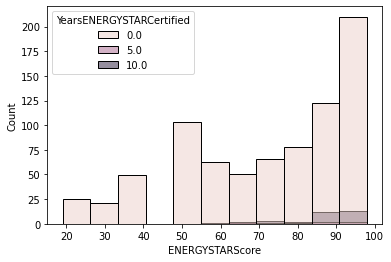

In [101]:
# On voit que l'échelle de réussite a bien bouger, ils n'ont pas réussi à tenir les mêmes résultats.
sns.histplot(x='ENERGYSTARScore',hue='YearsENERGYSTARCertified',\
             data=data_2016[data_2016['ENERGYSTARScore'].isin(verf_energ)][['ENERGYSTARScore','YearsENERGYSTARCertified']])
plt.savefig('image/YearsENERGYSTARCertified_4.png')

# 

#### SiteEUI(kBtu/sf)  & SiteEUIWN(kBtu/sf)( normalisée en fonction du temps (WN) )
##### L'intensité d'utilisation de l'énergie du site (IUE) est la consommation d'énergie du site d'une propriété divisée par sa surface de plancher brute. La consommation énergétique du site est la quantité annuelle de toute l'énergie consommée        par la propriété sur le site, telle qu'elle est indiquée sur les factures de services publics. Le site EUI est mesuré en        milliers d'unités thermiques britanniques (kBtu) par pied carré.
#### ---------------------------------------------------------------------------------------------------------------

#### SiteEnergyUse(kBtu) & SiteEnergyUseWN(kBtu)( ajustée  aux conditions météorologiques moyennes sur 30 ans.)
##### La quantité annuelle d'énergie consommée par la propriété à partir de toutes les sources d'énergie.



In [102]:
# Une autre type d'anomalie (l'entreprise existe, mais elle ne consomme pas l'energie)
data_2015['SiteEnergyUse(kBtu)'].min()

0.0

In [103]:
data_2015[data_2015['SiteEnergyUse(kBtu)'] == 0.0]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Neighborhood,YearBuilt,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,YearsENERGYSTARCertified,DefaultData,ComplianceStatus,Outlier,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
44,58,2015,NonResidential,Retail Store,CENTURY SQUARE RETAIL,1975700365,Downtown,1920,"Non-Refrigerated Warehouse, Other, Retail Store",Retail Store,Non-Refrigerated Warehouse,Other,0.0,No,Compliant,NaN,1.0,2.0,57428.0,0.0,57428.0,34617.0,13028.0,9783.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
571,765,2015,NonResidential,Large Office,SEATTLE TOWER,1975200005,Downtown,1929,"Office, Other - Technology/Science, Parking",Office,Parking,Other - Technology/Science,10.0,No,Compliant,NaN,1.0,27.0,216571.0,13320.0,203251.0,182604.0,13320.0,6246.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
# on la touche pas (apparemment il y avait un changement du "PropertyName")

data_2016[data_2016['OSEBuildingID'] == 58] 

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Neighborhood,YearBuilt,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,YearsENERGYSTARCertified,DefaultData,ComplianceStatus,Outlier,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
45,58,2016,NonResidential,Other,1525 4th Avenue,1975700365,Downtown,1920,"Other - Mall, Personal Services (Health/Beauty, Dry Cleaning, etc)",Other - Mall,"Personal Services (Health/Beauty, Dry Cleaning, etc)",NaN,0.0,False,Compliant,NaN,1.0,2.0,57428.0,0.0,57428.0,51747.0,5681.0,NaN,NaN,21.700001,21.6,48.799999,48.400002,1247362.0,1239429.75,0.0,209536.5938,714939.0,5324.230469,532423.0,33.26,0.58


In [105]:
# on la touche pas aussi, car 'PropertyGFATotal' devenu plus grand et 'NumberofFloors aussi

data_2016[data_2016['OSEBuildingID'] == 765] 

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Neighborhood,YearBuilt,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,YearsENERGYSTARCertified,DefaultData,ComplianceStatus,Outlier,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
571,765,2016,NonResidential,Large Office,Seattle Tower,1975200005,Downtown,1929,"Office, Other - Technology/Science, Parking",Office,Parking,Other - Technology/Science,5.0,False,Compliant,NaN,1.0,27.0,216571.0,13320.0,203251.0,182604.0,13320.0,6246.0,62.0,86.0,91.900002,192.699997,199.699997,16246106.0,17352520.0,7413886.0,2551222.75,8704772.0,1274.469971,127447.0,639.72,2.95


In [106]:
# Les écoles de Sydney reçoivent une attention particulière

(data_2016[data_2016['SiteEnergyUse(kBtu)'] == 0.0]['BuildingType']).value_counts()

SPS-District K-12       14
NonResidential          2 
Multifamily LR (1-4)    2 
Name: BuildingType, dtype: int64

In [107]:
# En général, en Seattle sont 98 ecoles, mais il nous manque d'infos sur ces 14 établissements pour comprendre cette situation 
len(data_2016[data_2016['BuildingType'] =='SPS-District K-12' ])

98

In [108]:
# Il n'y a pas de différences claires entre les caractéristiques de ces objets 
data_2016[(data_2016['SiteEnergyUse(kBtu)'] == 0.0)&(data_2016['BuildingType'] =='SPS-District K-12')]\
[['Neighborhood','YearsENERGYSTARCertified', 'DefaultData', 'ComplianceStatus','Outlier']]

,Neighborhood,YearsENERGYSTARCertified,DefaultData,ComplianceStatus,Outlier
28,Central,0.0,False,Missing Data,NaN
31,Magnolia / queen anne,0.0,False,Missing Data,NaN
62,Southwest,0.0,False,Missing Data,NaN
81,Delridge,0.0,False,Missing Data,NaN
85,Southeast,0.0,False,Missing Data,NaN
95,Lake union,0.0,False,Missing Data,NaN
133,Ballard,0.0,False,Missing Data,NaN
139,Central,0.0,False,Missing Data,NaN
152,North,0.0,False,Missing Data,NaN
614,Central,0.0,False,Missing Data,NaN


In [109]:
id_energie_zero_2016 = data_2016[data_2016['SiteEnergyUse(kBtu)'] == 0.0]['OSEBuildingID']

In [110]:
print("La quantité de ces propriétés  en 2015 : ",data_2015[data_2015['OSEBuildingID'].isin(id_energie_zero_2016)].shape[0]) 
id_energie_zero_2015 = data_2015[data_2015['OSEBuildingID'].isin(id_energie_zero_2016)]['OSEBuildingID']


La quantité de ces propriétés  en 2015 :  17


In [111]:
print( "Les propriétés avec \"ID\" {} ne fonctionnait pas en 2015 ".format(set(id_energie_zero_2016)-set(id_energie_zero_2015)))
ecole_13_correction  = data_2015[data_2015['OSEBuildingID'].isin(id_energie_zero_2016)][['OSEBuildingID','SourceEUI(kBtu/sf)','SiteEnergyUse(kBtu)','SteamUse(kBtu)',
       'Electricity(kBtu)','NaturalGas(kBtu)', 'TotalGHGEmissions']]

ecole_13_correction # on garde les "TD" pour de plus amples recherches

Les propriétés avec "ID" {87} ne fonctionnait pas en 2015 


,OSEBuildingID,SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions
28,34,84.2,6283226.0,0.0,1933106.0,4350200.0,244.51
31,37,83.8,1472548.0,0.0,1472609.0,0.0,10.27
80,118,70.9,1857329.0,0.0,1591795.0,265600.0,25.20
84,122,111.2,2150120.0,0.0,2150209.0,0.0,14.99
94,140,95.9,2033074.0,0.0,2033159.0,0.0,14.17
131,217,62.4,5674450.0,0.0,1936530.0,3738000.0,212.02
137,227,78.6,5436057.0,0.0,2388755.0,3047400.0,178.50
150,242,69.5,1227290.0,0.0,1227341.0,0.0,8.56
304,435,192.5,77164568.0,16811018.0,58718556.0,1637420.0,1793.90
617,820,113.2,1907697.0,0.0,1907776.0,0.0,13.30


In [112]:
data_2016['SiteEnergyUse(kBtu)'].isna().sum()

5

####  La correction            (***nous pouvons calculer le ratio avant de faire un  simple " copier et coller " de ces valeurs de 2015 et de soumettre à 2016, en divisant les colonnes contenant les informations sur l'énergie et le CO2 des deux dataframes, mais pour le moment nous avons un autre objectif à atteindre)

In [113]:
# La fonction de correction 

def remplissage_energie(colonne):
    for i in range(data_2016.shape[0]):
        if data_2016.loc[i,colonne+str('_x')] == 0.0 and data_2016.loc[i,colonne+str('_y')] != np.nan:
            data_2016.loc[i,colonne+str('_x')] += data_2016.loc[i,colonne+str('_y')] 

In [114]:
data_2016 =pd.merge(data_2016,ecole_13_correction, on='OSEBuildingID', how='left')

nouvelles_donnees_2016 = ['SourceEUI(kBtu/sf)','SiteEnergyUse(kBtu)','SteamUse(kBtu)',\
       'Electricity(kBtu)','NaturalGas(kBtu)', 'TotalGHGEmissions'] 

for col in nouvelles_donnees_2016:
    remplissage_energie(col)
    


In [115]:
suff_y  = [col for col in data_2016.columns if '_y' in col] # la liste des colonnes avec une suffixe _x
data_2016.drop(columns=suff_y, inplace=True) # suppression
data_2016.columns = data_2016.columns.str.replace('_x','') # recuperation les noms des anciennes colonnes 

print(data_2016['SiteEnergyUse(kBtu)'].isna().sum())

6


In [116]:
# Verif
print("Valeur minimale en 2016 est:", data_2016['SiteEnergyUse(kBtu)'].min())
data_2016[data_2016['OSEBuildingID'].isin(id_energie_zero_2015)]['SiteEnergyUse(kBtu)']

Valeur minimale en 2016 est: 13409.0


28      6283226.0 
31      1472548.0 
81      1857329.0 
85      2150120.0 
95      2033074.0 
133     5674450.0 
139     5436057.0 
152     1227290.0 
304     77164568.0
614     1907697.0 
630     1520326.0 
746     1173650.0 
760     670779.0  
1361    2255905.0 
1549    1497021.0 
1894    1499128.0 
3166    6344171.0 
Name: SiteEnergyUse(kBtu), dtype: float64

# 

#####  *** SiteEUI(kBtu/sf)=  SiteEnergyUse(kBtu) / LargestPropertyUseTypeGFA ***

In [117]:
# Creation de la colonne temporaire, pour prouver la formule ci-dessus 
data_2015['temporaire'] = data_2015['SiteEnergyUse(kBtu)']/data_2015['LargestPropertyUseTypeGFA']
data_2016['temporaire'] = data_2016['SiteEnergyUse(kBtu)']/data_2016['LargestPropertyUseTypeGFA']

In [118]:
# Calculons la diff
data_2015['diff'] = data_2015['SiteEUI(kBtu/sf)']-data_2015['temporaire']
data_2016['diff'] = data_2016['SiteEUI(kBtu/sf)']-data_2016['temporaire']


In [119]:
data_2015['diff'].dropna(inplace=True)
data_2016['diff'].dropna(inplace=True)

In [120]:
# Il y a quelques  petits erreurs de saisie (utilisé plus, mais enregistré moins )
data_2015[['SiteEUI(kBtu/sf)','temporaire','diff','SiteEUIWN(kBtu/sf)']].sample(5)

,SiteEUI(kBtu/sf),temporaire,diff,SiteEUIWN(kBtu/sf)
1869,27.4,27.359644,0.040356,32.6
2757,46.6,46.571771,0.028229,51.4
1434,45.2,90.062476,-44.862476,49.6
864,24.1,24.098522,0.001478,27.2
2163,49.6,49.576269,0.023731,47.5


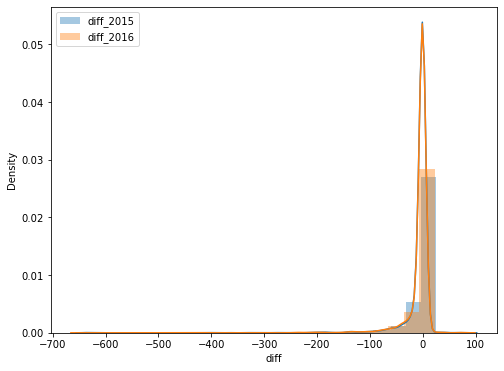

In [121]:
plt.figure(figsize=(8,6))
sns.distplot(data_2015['diff'], bins=25, label='diff_2015')
sns.distplot(data_2016['diff'], bins=25, label='diff_2016')
plt.legend()

In [122]:
# Suppression des colonnes temporaires
data_2015.drop(columns=['temporaire','diff'], inplace=True)
data_2016.drop(columns=['temporaire','diff'], inplace=True)

<AxesSubplot:>

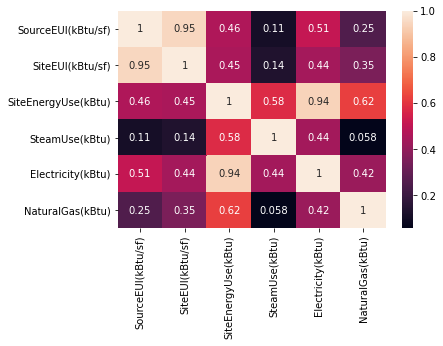

In [123]:
sns.heatmap(data_2015[['SourceEUI(kBtu/sf)','SiteEUI(kBtu/sf)',\
           'SiteEnergyUse(kBtu)','SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)']].corr(),annot=True,fmt='.2g')

<Figure size 288x288 with 0 Axes>

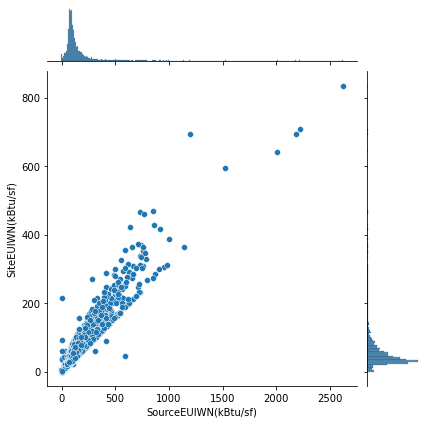

In [124]:
plt.figure(figsize=(4,4))
sns.jointplot(data_2016['SourceEUIWN(kBtu/sf)'],data_2016['SiteEUIWN(kBtu/sf)'])

In [125]:
# Remplissons les valeurs manquants dans la colonne 'LargestPropertyUseTypeGFA'

In [126]:
data_2015[['SourceEUI(kBtu/sf)','SiteEUI(kBtu/sf)',\
           'SiteEnergyUse(kBtu)','SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','LargestPropertyUseTypeGFA']].isna().sum()

SourceEUI(kBtu/sf)           4  
SiteEUI(kBtu/sf)             4  
SiteEnergyUse(kBtu)          4  
SteamUse(kBtu)               4  
Electricity(kBtu)            4  
NaturalGas(kBtu)             4  
LargestPropertyUseTypeGFA    136
dtype: int64

In [127]:
data_2016[['SourceEUI(kBtu/sf)','SiteEUI(kBtu/sf)',\
           'SiteEnergyUse(kBtu)','SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','LargestPropertyUseTypeGFA']].isna().sum()

SourceEUI(kBtu/sf)           16  
SiteEUI(kBtu/sf)             7   
SiteEnergyUse(kBtu)          6   
SteamUse(kBtu)               3229
Electricity(kBtu)            12  
NaturalGas(kBtu)             1254
LargestPropertyUseTypeGFA    20  
dtype: int64

In [128]:
# Récupération d'index 
val_manquants_property_2015 = data_2015[data_2015['LargestPropertyUseTypeGFA'].isna()].index
val_manquants_property_2016 = data_2016[data_2016['LargestPropertyUseTypeGFA'].isna()].index


In [129]:
# On utilise la formule 
for i in val_manquants_property_2016:
    data_2016['LargestPropertyUseTypeGFA'] = data_2016['SiteEnergyUse(kBtu)']/data_2016['SiteEUI(kBtu/sf)']     
for i in val_manquants_property_2015:
    data_2015['LargestPropertyUseTypeGFA'] = data_2015['SiteEnergyUse(kBtu)']/data_2015['SiteEUI(kBtu/sf)']        

### Vérification une autre formule 

In [130]:
data_2015['SiteEnergyUse(kBtu)'] 
col_verif = data_2015['Electricity(kBtu)']+data_2015['SteamUse(kBtu)']+data_2015['NaturalGas(kBtu)']

In [131]:
new_data_2015 = data_2015['SiteEnergyUse(kBtu)'].dropna()
col_verif = col_verif.dropna()

Ttest_indResult(statistic=-0.002501910424531686, pvalue=0.9980038413374529)


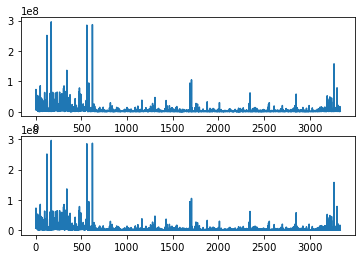

In [132]:
# Voici le resultat
fig, (ax1,ax2) = plt.subplots(2,1)
new_data_2015.plot(ax = ax1)
col_verif.plot(ax = ax2)
print(ttest_ind(new_data_2015,col_verif))

In [133]:
# Donc on peut essayer trouver les valeurs manquants : BaturalGaz+SteamUse = SiteEnergyUse-Electricity

def x(a,b):
    return a - b

data_2016['NaturalGaz_SteamUse'] = data_2016.apply(lambda f:x(f['SiteEnergyUse(kBtu)'],f['Electricity(kBtu)']), axis=1)
  

In [134]:
# la colonne "NaturalGaz_SteamUse" >= 0 (positive), mais on a beaucoup de valeurs négatives
data_2016[['NaturalGas(kBtu)','SteamUse(kBtu)','NaturalGaz_SteamUse']].sample(5)

,NaturalGas(kBtu),SteamUse(kBtu),NaturalGaz_SteamUse
572,NaN,NaN,3.000
2345,NaN,NaN,0.125
582,NaN,4047481.0,4047483.000
3215,2864680.0,NaN,2864680.500
2597,NaN,NaN,-0.125


In [135]:
data_2016['NaturalGaz_SteamUse'][data_2016['NaturalGaz_SteamUse']<0].sort_values()

3350   -1.774677e+06
85     -1.970180e+05
95     -7.121200e+04
614    -4.957100e+04
31     -2.426800e+04
1549   -6.200000e+01
152    -5.100000e+01
2546   -6.250000e-01
3152   -6.015600e-01
1762   -5.937000e-01
2249   -5.937000e-01
2182   -5.937000e-01
1691   -5.000000e-01
2621   -5.000000e-01
2666   -5.000000e-01
1295   -5.000000e-01
1788   -5.000000e-01
1530   -5.000000e-01
2743   -5.000000e-01
2836   -5.000000e-01
2889   -5.000000e-01
3012   -5.000000e-01
1564   -5.000000e-01
1254   -5.000000e-01
2258   -5.000000e-01
2494   -5.000000e-01
1950   -5.000000e-01
1965   -4.062000e-01
2352   -4.062000e-01
2956   -4.062000e-01
957    -4.062000e-01
2211   -4.062000e-01
1497   -3.984000e-01
2732   -3.750000e-01
2072   -3.750000e-01
1451   -3.750000e-01
2063   -3.750000e-01
2816   -3.750000e-01
1364   -3.750000e-01
2867   -3.750000e-01
2272   -3.750000e-01
1454   -3.750000e-01
2373   -3.750000e-01
2544   -3.750000e-01
2427   -3.750000e-01
1826   -3.750000e-01
2501   -3.750000e-01
1723   -3.750

In [136]:
# Par example
data_2016.loc[3350,:]

OSEBuildingID                      50086                       
DataYear                           2016                        
BuildingType                       Multifamily LR (1-4)        
PrimaryPropertyType                Low-Rise Multifamily        
PropertyName                       Interbay Place              
TaxParcelIdentificationNumber      2771601160                  
Neighborhood                       Magnolia / queen anne       
YearBuilt                          2015                        
ListOfAllPropertyUseTypes          Multifamily Housing, Parking
LargestPropertyUseType             Multifamily Housing         
SecondLargestPropertyUseType       Parking                     
ThirdLargestPropertyUseType        NaN                         
YearsENERGYSTARCertified           0                           
DefaultData                        False                       
ComplianceStatus                   Compliant                   
Outlier                            NaN  

In [137]:
ind = data_2016['NaturalGaz_SteamUse'][data_2016['NaturalGaz_SteamUse']<0].sort_values().index

In [138]:
# On va appliquer les valeurs de la colonne "Electricity(kBtu)" a la colonne "SiteEnergyUse(kBtu)"
for i in ind:
    data_2016.loc[i,'SiteEnergyUse(kBtu)'] = data_2016.loc[i,'Electricity(kBtu)'] 

In [139]:
# Recalcule
def x(a,b):
    return a - b

data_2016['NaturalGaz_SteamUse'] = data_2016.apply(lambda f:x(f['SiteEnergyUse(kBtu)'],f['Electricity(kBtu)']), axis=1)

In [140]:
for i in range(data_2016.shape[0]):
    if np.abs(data_2016.loc[i,'NaturalGaz_SteamUse'])<10:
        data_2016.loc[i,'NaturalGas(kBtu)'] = 0.0
        data_2016.loc[i,'SteamUse(kBtu)'] = 0.0
data_2016.drop(columns='NaturalGaz_SteamUse', inplace=True)        

### DefaultData
##### La propriété a utilisé des données par défaut pour au moins une caractéristique de propriété
######  utilisé pour changer la valeur de "ComplianceStatus" - mes propres observations (peut-être qu'ils l'ont utilisé dans d'autres cas aussi ..)

In [141]:
data_2015[['DefaultData']].value_counts()

DefaultData
No             2790
Yes            543 
dtype: int64

In [142]:
data_2016[['DefaultData']].value_counts()

DefaultData
False          3263
True           113 
dtype: int64

In [143]:
# Recodage
data_2015['DefaultData'] = data_2015['DefaultData'].map({'No':0, 'Yes':1})
data_2016['DefaultData'] = data_2016['DefaultData'].map({False:0, True:1})

In [144]:
print(data_2015[data_2015['DefaultData']==1].shape)
print(data_2016[data_2016['DefaultData']==1].shape)

(543, 38)
(113, 38)


In [145]:
# Changement de type
data_2015['DefaultData'] = data_2015['DefaultData'].astype('category')
data_2016['DefaultData'] = data_2016['DefaultData'].astype('category')

### ComplianceStatus
##### Si une propriété a satisfait aux exigences d'analyse comparative énergétique pour l'année de déclaration en cours.

In [146]:
data_2015['ComplianceStatus'].value_counts()

Compliant        3331
Not Compliant    3   
Name: ComplianceStatus, dtype: int64

In [147]:
data_2016['ComplianceStatus'].value_counts()

Compliant                       3211
Error - Correct Default Data    113 
Non-Compliant                   37  
Missing Data                    15  
Name: ComplianceStatus, dtype: int64

In [148]:
# Regardons sur les 3 propriétés "Not Compliant" en 2015
data_2015[data_2015['ComplianceStatus'] == 'Not Compliant'][['OSEBuildingID', 'PrimaryPropertyType','PropertyName' ]]

,OSEBuildingID,PrimaryPropertyType,PropertyName
765,19798,Low-Rise Multifamily,SANDHURST APTS
1344,21548,Low-Rise Multifamily,PUGET VISTA APTS
1834,23508,Low-Rise Multifamily,SEAVIEW CONDOMINIUM


#### Même si nous allons les supprimer (car dans notre projet nous ne garderons que les immeubles non résidentiels), comparons leur situation en 2016. En fait, je recherche un lien entre les deux features "ComplianceStatus" et "DefaultData".

In [149]:
# Recuperation d'ID de 'Not Compliant' en 2015 et pour  comparaison avec 2016
not_compliant_2015 = data_2015[data_2015['ComplianceStatus'] == 'Not Compliant']['OSEBuildingID'].values
not_compliant_2015

[19798, 21548, 23508]
Categories (3334, int64): [1, 2, 3, 5, ..., 50055, 50057, 50058, 50059]

In [150]:
# les 2 sur 3 ont changé ses statuts 
data_2016[data_2016['OSEBuildingID'].isin(not_compliant_2015)][['ComplianceStatus','PropertyName', 'DefaultData']]

,ComplianceStatus,PropertyName,DefaultData
758,Non-Compliant,SANDHURST APTS,0
1336,Compliant,Puget Vista,0
1819,Compliant,Seaview Condominium Homeowners Association,0


In [151]:
# Aucun lien entre 'ComplianceStatus' et 'TotalGHGEmissions'
data_2015['TotalGHGEmissions'].describe()

count    3330.000000 
mean     108.949516  
std      405.727469  
min      0.000000    
25%      9.265000    
50%      32.740000   
75%      88.537500   
max      11824.890000
Name: TotalGHGEmissions, dtype: float64

In [152]:
# Toute les valeurs 'ComplianceStatus' ils ont mis par défaut 
data_2015[data_2015['DefaultData']==1][['ComplianceStatus','TotalGHGEmissions']].value_counts().sort_values()

ComplianceStatus  TotalGHGEmissions
Compliant         6.20                 1
                  653.50               1
                  609.13               1
                  608.53               1
                  602.12               1
                  583.63               1
                  529.47               1
                  463.12               1
                  406.74               1
                  392.65               1
                  127.56               1
                  377.09               1
                  346.25               1
                  324.63               1
                  319.73               1
                  315.85               1
                  313.83               1
                  313.53               1
                  312.59               1
                  294.93               1
                  294.12               1
                  292.92               1
                  291.28               1
                  287

In [153]:
# Idem
data_2016[data_2016['DefaultData']==1][['ComplianceStatus','TotalGHGEmissions']].value_counts().sort_values()

ComplianceStatus              TotalGHGEmissions
Error - Correct Default Data  359.09               1
                              266.05               1
                              242.36               1
                              238.48               1
                              226.06               1
                              225.19               1
                              207.79               1
                              206.01               1
                              201.05               1
                              188.07               1
                              170.84               1
                              168.88               1
                              270.18               1
                              157.88               1
                              145.35               1
                              124.92               1
                              124.77               1
                              123.71               

In [154]:
# Donc on peut supprimer les colonnes 'ComplianceStatus' et 'DefaultData'
data_2015.drop(columns=['ComplianceStatus','DefaultData'], inplace=True)
data_2016.drop(columns=['ComplianceStatus','DefaultData'], inplace=True)

### Outlier
##### Si une propriété est une valeur aberrante élevée ou faible (O/N)


In [155]:
data_2015['Outlier'].value_counts()

High Outlier    46
Low Outlier     36
Name: Outlier, dtype: int64

In [156]:
data_2015['Outlier'] = data_2015['Outlier'].str.lower()
data_2016['Outlier'] = data_2016['Outlier'].str.lower()

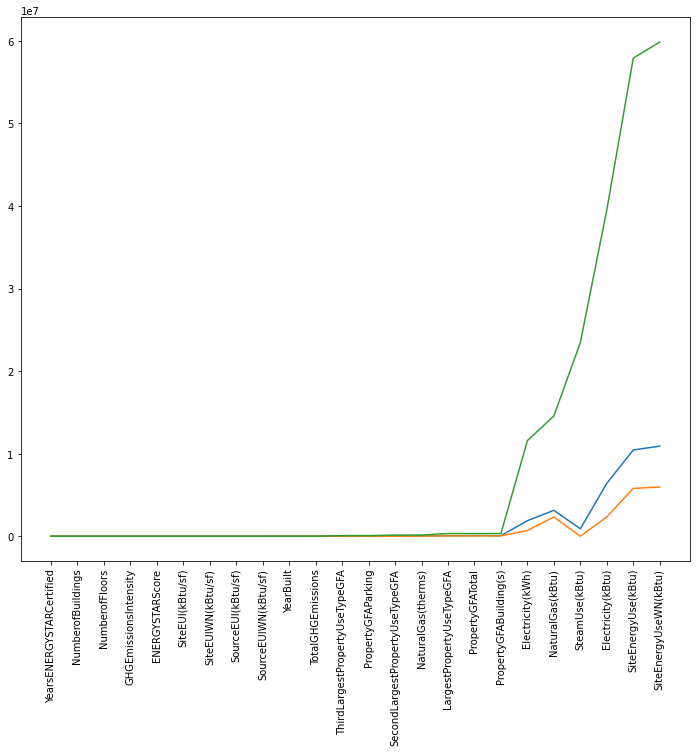

In [157]:
# Essayons de trouver la/les colonne qui a les valeurs aberrantes

plt.figure(figsize=(12,10))
plt.xticks(rotation=90)
plt.plot((data_2015[data_2015['Outlier'] == 'high outlier']).describe().T[['mean','50%','max']].sort_values(by ='max'));

In [158]:
# Il est clair qu'il faut rechercher ces valeurs parmi les caractéristiques associées à l'électricité, au gaz ou à la vapeur.
colonne_a_observer=['SiteEUI(kBtu/sf)','SiteEnergyUse(kBtu)',\
                    'SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)']

#### On a 2 colonnes avec les valeurs bien supérieures a leurs moyens : 'SiteEUI(kBtu/sf)' et 'SteamUse(kBtu)', mais la représentation graphique nous indique 2 autres colonnes : 'SiteEnergyUse(kBtu)' et 'NaturalGas(kBtu)' 


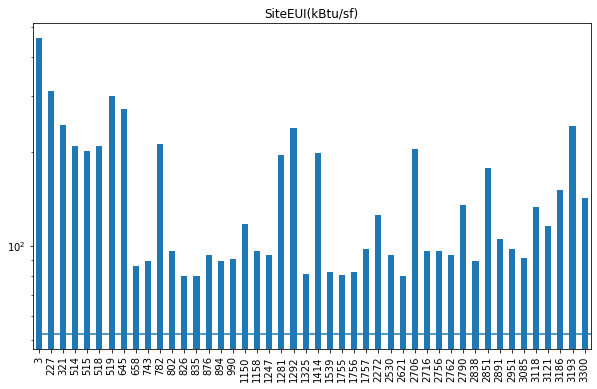

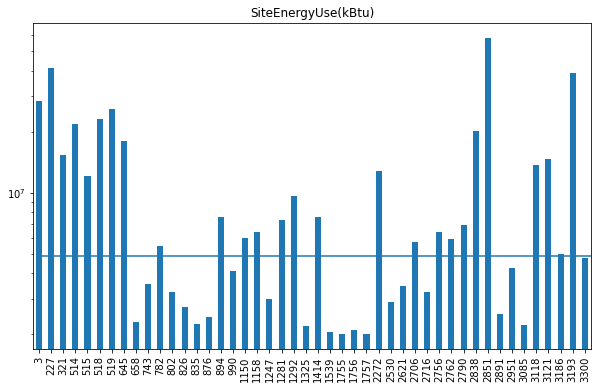

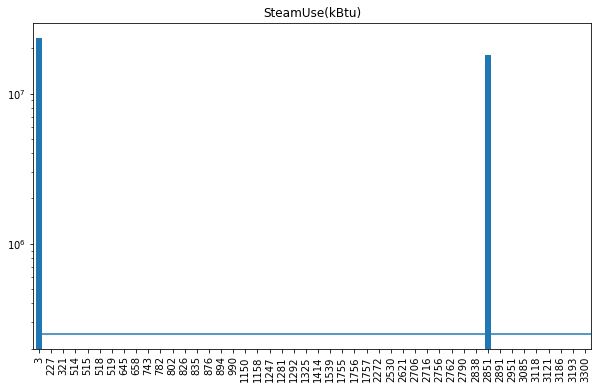

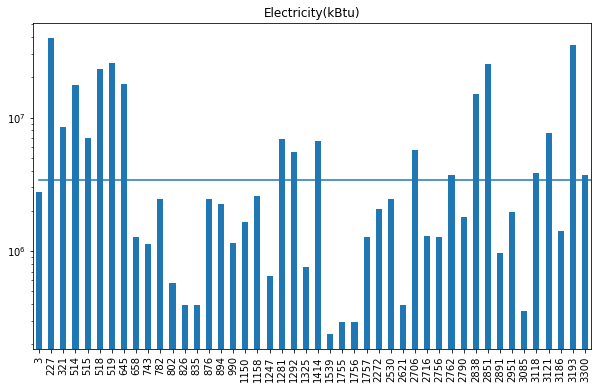

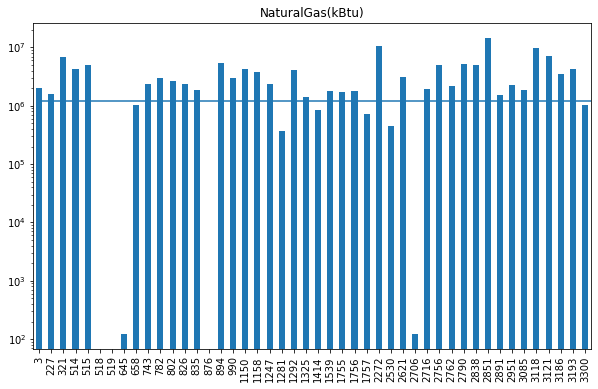

In [159]:
for i in colonne_a_observer:
    plt.figure(figsize=(10,6))
    plt.yscale("log")
    plt.title(i)
    (data_2015[data_2015['Outlier'] == 'high outlier'])[i].plot.bar()
    plt.plot(np.linspace(0,len(data_2015[data_2015['Outlier'] != 'high outlier'])),np.full(shape=50,fill_value= data_2015[data_2015['Outlier']\
                                                                                               !='high outlier'][i].mean(axis=0)))

In [160]:
# En tout cas, ça sera inutile de garder cette colonne 'Outlier'
data_2015.drop(columns=['Outlier'], inplace=True)
data_2016.drop(columns=['Outlier'], inplace=True)

<AxesSubplot:>

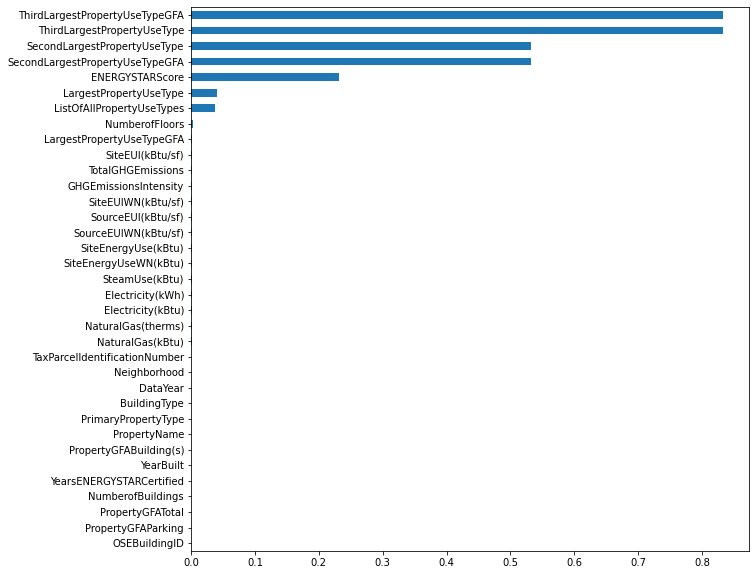

In [161]:
# Reste a nettoyer en 2015
plt.figure(figsize=(10, 10))
(data_2015.isna().sum()/data_2015.shape[0]).sort_values().plot.barh()

<AxesSubplot:>

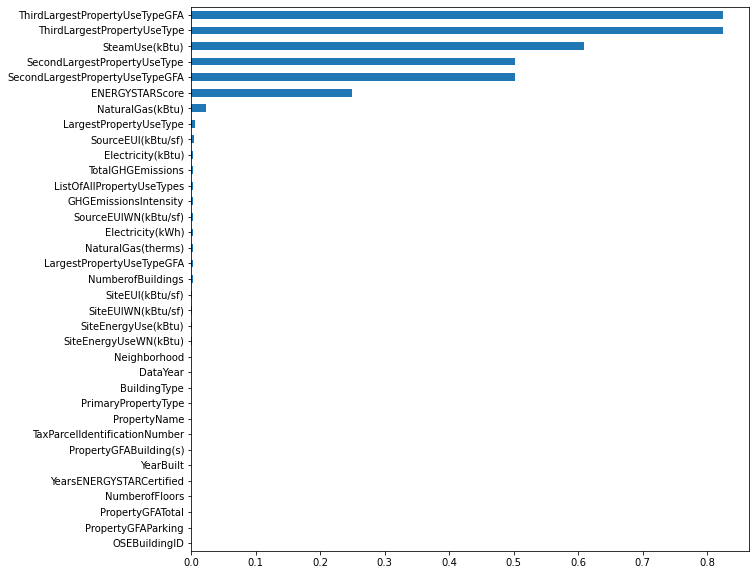

In [162]:
# Idem

plt.figure(figsize=(10, 10))
(data_2016.isna().sum()/data_2016.shape[0]).sort_values().plot.barh()

In [163]:
# On peut également supprimer les colonnes qui sont liés avec les conditions météo 
wn_2015 = [x for x in data_2015.columns if 'WN' in x]
wn_2016 = [x for x in data_2016.columns if 'WN' in x]

In [164]:
data_2015.drop(columns=wn_2015, inplace=True)
data_2016.drop(columns=wn_2016, inplace=True)

In [165]:
print(data_2015.shape,data_2016.shape)

(3334, 32) (3376, 32)


#### GHGEmissionsIntensity
##### Émissions totales de gaz à effet de serre divisées par la surface de plancher brute de la propriété, mesurée en                kilogrammes d'équivalent de dioxyde de carbone par pied carré. Ce calcul utilise un facteur d'émissions de GES du              portefeuille de ressources de production de Seattle City Light

#### TotalGHGEmissions
##### La quantité totale d'émissions de gaz à effet de serre, y compris le dioxyde de carbone, le méthane et les gaz d'oxyde          nitreux rejetés dans l'atmosphère en raison de la consommation d'énergie de la propriété, mesurée en tonnes métriques          d'équivalent en dioxyde de carbone. Ce calcul utilise un facteur d'émissions de GES du portefeuille de ressources de            production de Seattle City Light. Cela utilise le facteur d'émissions 2015 de Seattle City Light de 52,44 lb CO2e/MWh          jusqu'à ce que le facteur 2016 soit disponible. Facteur de vapeur Enwave = 170,17 lb CO2e/MMBtu. Facteur de gaz                provenant de l'EPA Portfolio Manager = 53,11 kg CO2e/MBtu.

<AxesSubplot:title={'center':'2016'}>

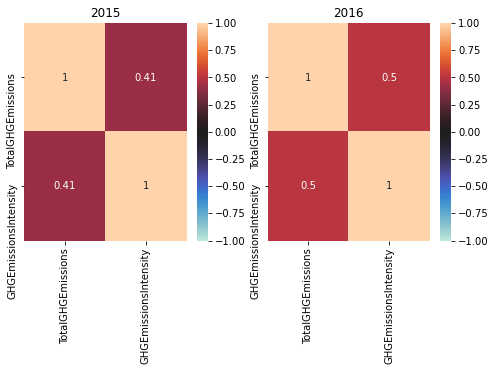

In [166]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title('2015')
sns.heatmap(data_2015[['TotalGHGEmissions', 'GHGEmissionsIntensity']].corr(), vmax=1,vmin=-1,center=0.0, annot=True)
plt.subplot(122)
plt.title('2016')
sns.heatmap(data_2016[['TotalGHGEmissions', 'GHGEmissionsIntensity']].corr(), vmax=1,vmin=-1,center=0.0, annot=True)

#### Sont-elles les mêmes moyennes ces 2 échantillons ?

In [167]:
# Recuperation les mêmes propriétés 
index_commun = np.intersect1d(data_2015['OSEBuildingID'].values, data_2016['OSEBuildingID'].values)
len(index_commun)

3279

In [168]:
"""
On va creer 2 échantillons pour comparer le p-value:
Hippothèse 0: aucune differance entre ces 2 échantillons 
Hippothèse 1: les moyennes de ces 2 échantillons assez éloigné

"""
echantillon_2015_CO2 = data_2015[data_2015['OSEBuildingID'].isin(index_commun)]['GHGEmissionsIntensity'].notna().values
echantillon_2016_CO2 = data_2016[data_2016['OSEBuildingID'].isin(index_commun)]['TotalGHGEmissions'].notna().values

In [169]:
ttest_ind(echantillon_2015_CO2,echantillon_2016_CO2) # Oui, on accepte, plus grand que 0.05

Ttest_indResult(statistic=1.3881192841232968, pvalue=0.16514789257022516)

In [170]:
# On va decouvrir les propriétés qui travaille sans avoir le numero de 'TaxParcelIdentificationNumber'
(data_2015[data_2015['TaxParcelIdentificationNumber'].isna()])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Neighborhood,YearBuilt,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,YearsENERGYSTARCertified,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
3187,43948,2015,Nonresidential COS,Other,GEORGETOWN STEAM PLANT,NaN,Greater duwamish,1906,Other,Other,NaN,NaN,0.0,1.0,NaN,39212.0,0.0,39212.0,39239.238579,NaN,NaN,NaN,19.7,61.9,773013.0,0.0,226557.0,773045.0,0.0,0.0,5.39,0.05
3229,49769,2015,Multifamily MR (5-9),Mid-Rise Multifamily,Test MF High Use (ID 49769),NaN,Lake union,1920,Multifamily Housing,Multifamily Housing,NaN,NaN,0.0,1.0,5.0,43998.0,0.0,43998.0,31988.888889,NaN,NaN,100.0,31.5,35.8,1007650.0,0.0,12500.0,42652.0,9650.0,965000.0,51.55,1.17


In [171]:
# La propriété consomme l'énergie.On le garde (parce qu'il est "Nonresidential")
data_2015[data_2015['OSEBuildingID'] == 43948]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Neighborhood,YearBuilt,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,YearsENERGYSTARCertified,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
3187,43948,2015,Nonresidential COS,Other,GEORGETOWN STEAM PLANT,NaN,Greater duwamish,1906,Other,Other,NaN,NaN,0.0,1.0,NaN,39212.0,0.0,39212.0,39239.238579,NaN,NaN,NaN,19.7,61.9,773013.0,0.0,226557.0,773045.0,0.0,0.0,5.39,0.05


In [172]:
# En 2016
(data_2016[data_2016['TaxParcelIdentificationNumber'].isna()])

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Neighborhood,YearBuilt,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,YearsENERGYSTARCertified,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity


### Finition de la nettoyage des données   non informatives pour ce projet en 2015 et 2016

In [173]:
# Suppression 
data_2015.drop(columns=['Electricity(kWh)','NaturalGas(therms)','TaxParcelIdentificationNumber'], inplace=True)
data_2016.drop(columns=['Electricity(kWh)','NaturalGas(therms)','TaxParcelIdentificationNumber'], inplace=True)

In [174]:
# Maintenant on peut réunir nos 2 dataframes
compare_colums(data_2015,data_2016)
    

colonnes présentes sur données 2015 et absentes sur 2016 : 
 []

colonnes présentes sur données 2016 et absentes sur 2015 : 
 []


In [175]:
data = pd.concat([data_2016,data_2015], axis=0)
data.shape

(6710, 29)

In [176]:
data.isna().sum()

OSEBuildingID                      0   
DataYear                           0   
BuildingType                       0   
PrimaryPropertyType                0   
PropertyName                       0   
Neighborhood                       0   
YearBuilt                          0   
ListOfAllPropertyUseTypes          136 
LargestPropertyUseType             156 
SecondLargestPropertyUseType       3472
ThirdLargestPropertyUseType        5554
YearsENERGYSTARCertified           0   
NumberofBuildings                  8   
NumberofFloors                     8   
PropertyGFATotal                   0   
PropertyGFAParking                 0   
PropertyGFABuilding(s)             0   
LargestPropertyUseTypeGFA          14  
SecondLargestPropertyUseTypeGFA    3472
ThirdLargestPropertyUseTypeGFA     5554
ENERGYSTARScore                    1617
SiteEUI(kBtu/sf)                   11  
SourceEUI(kBtu/sf)                 20  
SiteEnergyUse(kBtu)                10  
SteamUse(kBtu)                     2057


In [177]:
"""
Pour compléter  les valeurs manquant dans la colonne 'ListOfAllPropertyUseTypes', 
on va regarder les colonnes directement lié à cette colonne 
"""
df_terrain  = data[data['ListOfAllPropertyUseTypes'].isna()][['OSEBuildingID','PrimaryPropertyType',\
                                                              'LargestPropertyUseTypeGFA','PropertyGFATotal', 'LargestPropertyUseType',\
                                                'SecondLargestPropertyUseTypeGFA','SecondLargestPropertyUseType',\
                                               'ThirdLargestPropertyUseTypeGFA','ThirdLargestPropertyUseType',\
                                               'PropertyGFABuilding(s)', 'PropertyGFAParking']]
df_terrain

,OSEBuildingID,PrimaryPropertyType,LargestPropertyUseTypeGFA,PropertyGFATotal,LargestPropertyUseType,SecondLargestPropertyUseTypeGFA,SecondLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,PropertyGFABuilding(s),PropertyGFAParking
578,773,Small- and Mid-Sized Office,NaN,63150.0,NaN,NaN,NaN,NaN,NaN,63150.0,0.0
758,19798,Low-Rise Multifamily,NaN,33166.0,NaN,NaN,NaN,NaN,NaN,33166.0,0.0
1768,23355,Low-Rise Multifamily,29358.498187,29357.0,NaN,NaN,NaN,NaN,NaN,29357.0,0.0
1792,23437,Low-Rise Multifamily,NaN,23636.0,NaN,NaN,NaN,NaN,NaN,23636.0,0.0
2321,25431,Low-Rise Multifamily,28423.449786,28472.0,NaN,NaN,NaN,NaN,NaN,28472.0,0.0
2474,25752,Low-Rise Multifamily,NaN,29562.0,NaN,NaN,NaN,NaN,NaN,21031.0,8531.0
2480,25763,Low-Rise Multifamily,30424.311594,30420.0,NaN,NaN,NaN,NaN,NaN,30420.0,0.0
2670,26532,Mixed Use Property,NaN,20760.0,NaN,NaN,NaN,NaN,NaN,20760.0,0.0
3348,50082,Low-Rise Multifamily,27249.837696,36685.0,NaN,NaN,NaN,NaN,NaN,28431.0,8254.0
10,15,Hotel,145596.963403,153163.0,NaN,NaN,NaN,NaN,NaN,133884.0,19279.0


In [178]:
# Les propriétés sans parking
df_terrain_sans_parking = df_terrain.loc[df_terrain[df_terrain['PropertyGFAParking'] == 0.0].index,:]['OSEBuildingID'].values


In [179]:
# Fonction pour remplir les données manquants 
def function_terrain(x, parking=0):
    k=data[data['OSEBuildingID'] == x].index
    data.loc[k,'ListOfAllPropertyUseTypes'] = data.loc[k,'PrimaryPropertyType']
    data.loc[k,'LargestPropertyUseType'] = data.loc[k,'PrimaryPropertyType']
    data.loc[k,'ThirdLargestPropertyUseType'] = 'pas de piece'
    data.loc[k,'ThirdLargestPropertyUseTypeGFA'] = 0.0
    if parking == 0:
        data.loc[k,'LargestPropertyUseTypeGFA'] = data.loc[k,'PropertyGFATotal']
        data.loc[k,'SecondLargestPropertyUseType'] = 'pas de piece'
        data.loc[k,'SecondLargestPropertyUseTypeGFA'] = 0.0
    else:
        data.loc[k,'LargestPropertyUseTypeGFA'] = data.loc[k,'PropertyGFATotal']-data.loc[k,'PropertyGFAParking']
        data.loc[k,'SecondLargestPropertyUseType'] = 'parking'
        data.loc[k,'SecondLargestPropertyUseTypeGFA'] = data.loc[k,'PropertyGFAParking']
        

In [180]:
for ind in df_terrain_sans_parking:
    function_terrain(ind,0)

In [181]:
# Les propriétés avec parking
df_terrain_avec_parking = df_terrain.loc[df_terrain[df_terrain['PropertyGFAParking'] > 0.0].index,:]['OSEBuildingID'].values

In [182]:
for ind in df_terrain_avec_parking:
    function_terrain(ind, parking= 1)

In [183]:
df_terrain_large = data[data['LargestPropertyUseType'].isna()][['OSEBuildingID','PrimaryPropertyType','PropertyGFATotal',\
                                             'PropertyGFAParking','PropertyGFABuilding(s)']]['OSEBuildingID'].values

In [184]:
for ind in df_terrain_large:
    function_terrain(ind, parking= 0)

In [185]:
for ind in df_terrain_large:
    function_terrain(ind, parking= 1)

In [186]:
data['SecondLargestPropertyUseType'].fillna(0.0,inplace=True)
data['ThirdLargestPropertyUseType'].fillna(0.0, inplace=True)

In [187]:
data.isna().sum()

OSEBuildingID                      0   
DataYear                           0   
BuildingType                       0   
PrimaryPropertyType                0   
PropertyName                       0   
Neighborhood                       0   
YearBuilt                          0   
ListOfAllPropertyUseTypes          0   
LargestPropertyUseType             0   
SecondLargestPropertyUseType       0   
ThirdLargestPropertyUseType        0   
YearsENERGYSTARCertified           0   
NumberofBuildings                  8   
NumberofFloors                     8   
PropertyGFATotal                   0   
PropertyGFAParking                 0   
PropertyGFABuilding(s)             0   
LargestPropertyUseTypeGFA          6   
SecondLargestPropertyUseTypeGFA    3151
ThirdLargestPropertyUseTypeGFA     5108
ENERGYSTARScore                    1617
SiteEUI(kBtu/sf)                   11  
SourceEUI(kBtu/sf)                 20  
SiteEnergyUse(kBtu)                10  
SteamUse(kBtu)                     2057


In [188]:
data.min(axis=1).sort_values()

3206   -115417.0
3240   -2.0     
0       0.0     
1103    0.0     
1102    0.0     
       ...      
571     1.0     
228     1.0     
53      1.0     
285     1.0     
2675    1.0     
Length: 6710, dtype: float64

In [189]:
"""
Apres quelques observations on constate que cet hôpital était en pleine rénovation, 
donc on va prendre les mêmes valeurs, mais un signe positif
"""

data.loc[3206,:].T

,3206,3206
OSEBuildingID,49784,49709
DataYear,2016,2015
BuildingType,NonResidential,NonResidential
PrimaryPropertyType,Small- and Mid-Sized Office,Other
PropertyName,Bullitt Center,NORTHWEST HOSPITAL & MEDICAL CENTER (NEW PROFESSIONAL BLDG)
Neighborhood,Central,Northwest
YearBuilt,2013,2012
ListOfAllPropertyUseTypes,Office,Urgent Care/Clinic/Other Outpatient
LargestPropertyUseType,Office,Urgent Care/Clinic/Other Outpatient
SecondLargestPropertyUseType,0,0


In [190]:
data.loc[(data['OSEBuildingID'] == 49784)&(data['DataYear'] == 2016.0),'Electricity(kBtu)'] = 115417
data.loc[(data['OSEBuildingID'] == 49784)&(data['DataYear'] == 2016.0),'NaturalGas(kBtu)'] = 342726-115417
data.loc[(data['OSEBuildingID'] == 49784)&(data['DataYear'] == 2016.0),'TotalGHGEmissions'] = 0.8
data.loc[(data['OSEBuildingID'] == 49784)&(data['DataYear'] == 2016.0),'GHGEmissionsIntensity'] = 0.02

### Numbers of floors

In [191]:
# Nombre d'étages non renseignés

data[data['NumberofFloors'].isna()].index

Int64Index([2011, 3165, 3166, 3167, 3187, 3203, 3305, 3307], dtype='int64')

In [192]:
data[data.index.isin(data[data['NumberofFloors'].isna()].index)][['NumberofFloors','SiteEnergyUse(kBtu)','DataYear']]

,NumberofFloors,SiteEnergyUse(kBtu),DataYear
2011,3.0,2.168702e+06,2016
3165,2.0,1.544194e+06,2016
3166,1.0,6.344171e+06,2016
3167,6.0,4.228238e+06,2016
3187,8.0,5.776441e+07,2016
3203,7.0,4.168064e+07,2016
3305,5.0,2.152312e+06,2016
3307,8.0,1.072488e+06,2016
2011,NaN,2.993920e+07,2015
3165,NaN,1.541183e+07,2015


In [193]:
for i in data[data['NumberofFloors'].isna()].index:
    data.loc[(data.index == i)&(data['DataYear'] == 2015.0),'NumberofFloors'] = data.loc[(data.index == i)&(data['DataYear'] == 2016.0),'NumberofFloors']

### Nombre de bâtiments

In [194]:
data[data.index.isin(data[data['NumberofBuildings'].isna()].index)][['NumberofBuildings','SiteEnergyUse(kBtu)','DataYear']]

,NumberofBuildings,SiteEnergyUse(kBtu),DataYear
578,NaN,NaN,2016
758,NaN,NaN,2016
1768,NaN,5.636832e+05,2016
1792,NaN,NaN,2016
2321,NaN,7.702755e+05,2016
2474,NaN,NaN,2016
2480,NaN,1.049639e+06,2016
2670,NaN,NaN,2016
578,1.0,2.982178e+06,2015
758,1.0,3.065502e+06,2015


In [195]:
# Remplaçons les NaN avec la valeur 1.0 (comme en 2015)
for i in data[data['NumberofBuildings'].isna()].index:
    data.loc[(data.index == i)&(data['DataYear'] == 2016.0),'NumberofBuildings'] = 1.0

In [196]:
threshold = 0.7
corr = data.corr()
corr_pairs = corr.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold)])
               .reset_index().rename(columns={0:'corr_coeff'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('corr_coeff', ascending=False)

,level_0,level_1,corr_coeff
22,PropertyGFATotal,PropertyGFABuilding(s),0.978620
20,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),0.948121
18,Electricity(kBtu),SiteEnergyUse(kBtu),0.926173
16,SiteEnergyUse(kBtu),TotalGHGEmissions,0.903925
14,TotalGHGEmissions,SteamUse(kBtu),0.859437
12,SecondLargestPropertyUseTypeGFA,PropertyGFATotal,0.807855
10,SecondLargestPropertyUseTypeGFA,PropertyGFABuilding(s),0.786766
8,NaturalGas(kBtu),TotalGHGEmissions,0.754727
6,SecondLargestPropertyUseTypeGFA,LargestPropertyUseTypeGFA,0.743110
4,SiteEUI(kBtu/sf),GHGEmissionsIntensity,0.725860


In [197]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6710 entries, 0 to 3333
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    6710 non-null   int64  
 1   DataYear                         6710 non-null   int64  
 2   BuildingType                     6710 non-null   object 
 3   PrimaryPropertyType              6710 non-null   object 
 4   PropertyName                     6710 non-null   object 
 5   Neighborhood                     6710 non-null   object 
 6   YearBuilt                        6710 non-null   int64  
 7   ListOfAllPropertyUseTypes        6710 non-null   object 
 8   LargestPropertyUseType           6710 non-null   object 
 9   SecondLargestPropertyUseType     6710 non-null   object 
 10  ThirdLargestPropertyUseType      6710 non-null   object 
 11  YearsENERGYSTARCertified         6710 non-null   float64
 12  NumberofBuildings   

In [198]:
for i in data.select_dtypes('object'):
    print(i)

BuildingType
PrimaryPropertyType
PropertyName
Neighborhood
ListOfAllPropertyUseTypes
LargestPropertyUseType
SecondLargestPropertyUseType
ThirdLargestPropertyUseType


In [199]:
for i in data.select_dtypes('object').columns:
    print(i, data[i].unique())

BuildingType ['NonResidential' 'Nonresidential COS' 'Multifamily MR (5-9)'
 'SPS-District K-12' 'Campus' 'Multifamily LR (1-4)'
 'Multifamily HR (10+)' 'Nonresidential WA']
PrimaryPropertyType ['Hotel' 'Other' 'Mid-Rise Multifamily' 'Mixed Use Property' 'K-12 School'
 'University' 'Small- and Mid-Sized Office' 'Self-Storage Facility'
 'Warehouse' 'Large Office' 'Senior Care Community' 'Medical Office'
 'Retail Store' 'Hospital' 'Residence Hall' 'Distribution Center'
 'Worship Facility' 'Low-Rise Multifamily' 'Supermarket / Grocery Store'
 'Laboratory' 'Refrigerated Warehouse' 'Restaurant'
 'High-Rise Multifamily' 'Office' 'College/University'
 'Residence Hall/Dormitory' 'Non-Refrigerated Warehouse'
 'SPS-District K-12' 'Supermarket/Grocery Store']
PropertyName ['Mayflower park hotel' 'Paramount Hotel' '5673-The Westin Seattle' ...
 'CIRRUS' 'WEDGEWOOD ESTATES BLDG A' 'WEDGEWOOD ESTATES BLDG B']
Neighborhood ['Downtown' 'Southeast' 'Northeast' 'East' 'Central' 'North'
 'Magnolia / queen

In [200]:
codage_du_type  = ['BuildingType','PrimaryPropertyType','LargestPropertyUseType','SecondLargestPropertyUseType','ThirdLargestPropertyUseType']

In [201]:
obj_dict = {
                'repair services (vehicle, shoe, locksmith, etc)' : 'service',
                'personal services': 'service',
                'food service': 'service' ,
                'other - services' : 'service',
                'office, other - entertainment/public assembly, restaurant, urgent care/clinic/other outpatient ' : 'service/commerce/loisirs',
                'other - mall, personal services (health/beauty, dry cleaning, etc)' : 'service',
                'food service, retail store, supermarket/grocery store' : 'service',
                'personal services (health/beauty, dry cleaning, etc)' : 'service',

                'retail store' : 'commerce',
                'supermarket/grocery store' : 'commerce',
                'other, supermarket/grocery store' : 'commerce', 
                'food sales': 'commerce',
                'automobile dealership': 'commerce',
                'convenience store without gas station': 'commerce',
                'distribution center' : 'commerce',
                'enclosed mall': 'commerce',
                'enclosed mall, office': 'commerce',
                'strip mall': 'commerce',
                'wholesale club/supercenter': 'commerce',
                'other - mall': 'commerce',
                'supermarket / grocery store': 'commerce',    

                'restaurant' : 'loisirs',
                'other - restaurant/bar' : 'loisirs',
                'fitness center/health club/gym, multifamily housing, personal services (health/beauty, dry cleaning, etc)' : 'service/commerce/loisirs',                'worship facility': 'loisirs',
                'other - recreation': 'loisirs',
                'other - entertainment/public assembly': 'loisirs',
                'performing arts': 'loisirs',
                'bar/nightclub': 'loisirs',
                'movie theater': 'loisirs',
                'museum': 'loisirs',
                'social/meeting hall': 'loisirs',
                'fitness center/health club/gym': 'loisirs',
                'lifestyle center ': 'loisirs',
                'fast food restaurant': 'loisirs',
                'movie theater, office, vocational school': 'loisirs',
                'swimming pool': 'loisirs',
                'lifestyle center': 'loisirs',
                
                'multifamily housing' : 'multifamily',
                'other - lodging/residential': 'multifamily',
                'residence hall/dormitory': 'multifamily',
                'hotel' : 'service',
                'senior care community' : 'loisirs',
                'residential care facility' : 'multifamily',
                'high-rise multifamily': 'multifamily',
                'residence hall': 'multifamily',
                'mid-rise multifamily': 'multifamily',
                'low-rise multifamily': 'multifamily',
                'mixed use property': 'service',
                'multifamily housing, other - lodging/residential, parking': 'multifamily',
                'multifamily housing, other, other - lodging/residential' :'multifamily',
            
                'multifamily housing, senior care community': 'multifamily',
                'medical Office' : 'etablissement medical',
                'medical office' : 'etablissement medical',
                'hospital' : 'etablissement medical',
                'laboratory, medical office' : 'etablissement medical',
                'laboratory' : 'etablissement medical',
                'other/specialty hospital' : 'etablissement medical',                    
                'urgent care/clinic/other outpatient' : 'etablissement medical',
                'hospital (general medical & surgical)' : 'etablissement medical',

                'large office' : 'office',
                'bank branch' : 'office',
                'financial office' : 'office',
                'other - public services': 'office',
                'small- and mid-sized office': 'office',
                'bank branch, retail store': 'office',

                'k-12 school' : 'education',
                'other - Education': 'education',
                'vocational school' : 'education', 
                'adult Education' : 'education',
                'pre-school/daycare': 'education',
                'university': 'education',
                'college/university': 'education',
                'library': 'education',
                'sps-district k-12' : 'education',
                'other - education' : 'education',
                'adult education' : 'education',
                'other - technology/science' : 'education',

                'warehouse' : 'depot',
                'non-refrigerated warehouse' : 'depot',
                'refrigerated warehouse' : 'depot',
                'self-storage facility' : 'depot',
                'laboratory, non-refrigerated warehouse, office, other - utility' : 'depot',

                'manufacturing/industrial plant':'industrie',

                'other - utility': 'other'
               }

In [202]:
# Attribution 
for col in codage_du_type:
    data[col] = data[col].replace(obj_dict)

In [203]:
for i in data.select_dtypes('object').columns:
    data[i] = data[i].str.lower()

In [204]:
# Suppression des bâtiments  destinés à l’habitation
data = data[~data['BuildingType'].str.contains('multifamily'or'low-rise multifamily'or'multifamily housing')]

In [205]:
# On ne va pas  les utiliser 
data.drop(columns=['ListOfAllPropertyUseTypes', 'PropertyName'], inplace=True)

In [206]:
# Changement de type
data['Neighborhood'] = data['Neighborhood'].astype('category').cat.codes

In [207]:
data.shape

(3312, 27)

In [208]:
# Voici la liste complète des entreprises non destinés à l’habitation
for col in codage_du_type:
    print(data[col].value_counts())
    print('\n')

nonresidential        2921
sps-district k-12     191 
nonresidential cos    153 
campus                46  
nonresidential wa     1   
Name: BuildingType, dtype: int64


small- and mid-sized office    588
other                          502
large office                   344
k-12 school                    269
mixed use property             220
retail store                   191
non-refrigerated warehouse     187
warehouse                      187
hotel                          149
worship facility               143
distribution center            106
medical office                 82 
self-storage facility          56 
supermarket / grocery store    40 
senior care community          39 
supermarket/grocery store      36 
refrigerated warehouse         25 
restaurant                     24 
university                     24 
college/university             21 
residence hall                 21 
hospital                       20 
residence hall/dormitory       15 
laboratory               

In [209]:
# Je suis sur que s'est encore possible de récupérer les valeurs proprement. Peut être après on revient la dessus.
data['SecondLargestPropertyUseType'] = data['SecondLargestPropertyUseType'].fillna('pas de piece')
data['ThirdLargestPropertyUseType'] = data['ThirdLargestPropertyUseType'].fillna('pas de piece')
data['SecondLargestPropertyUseTypeGFA'] = data['SecondLargestPropertyUseTypeGFA'].fillna(0.0)
data['ThirdLargestPropertyUseTypeGFA'] = data['ThirdLargestPropertyUseTypeGFA'].fillna(0.0)
data['NaturalGas(kBtu)'] = data['NaturalGas(kBtu)'].fillna(0.0)
data['SteamUse(kBtu)'] = data['SteamUse(kBtu)'].fillna(0.0)

In [210]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3312 entries, 0 to 3328
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3312 non-null   int64  
 1   DataYear                         3312 non-null   int64  
 2   BuildingType                     3312 non-null   object 
 3   PrimaryPropertyType              3312 non-null   object 
 4   Neighborhood                     3312 non-null   int8   
 5   YearBuilt                        3312 non-null   int64  
 6   LargestPropertyUseType           3312 non-null   object 
 7   SecondLargestPropertyUseType     3312 non-null   object 
 8   ThirdLargestPropertyUseType      3312 non-null   object 
 9   YearsENERGYSTARCertified         3312 non-null   float64
 10  NumberofBuildings                3312 non-null   float64
 11  NumberofFloors                   3312 non-null   float64
 12  PropertyGFATotal    

In [211]:
data.select_dtypes(['float','int64']).columns

Index(['OSEBuildingID', 'DataYear', 'YearBuilt', 'YearsENERGYSTARCertified',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions',
       'GHGEmissionsIntensity'],
      dtype='object')

In [212]:
# Supprimons les doublons en prenant le moyen de 2 ans : 2015 et 2016

mean_columns = ['YearsENERGYSTARCertified',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'TotalGHGEmissions',
       'GHGEmissionsIntensity']
data_mean = data[['OSEBuildingID']+mean_columns].groupby('OSEBuildingID').mean()
data_mean.shape


(1697, 18)

In [213]:

duplicate_building = data.drop_duplicates(subset=['OSEBuildingID'], keep='last')
duplicate_building.drop(mean_columns, axis=1, inplace=True)
data = pd.merge(duplicate_building, data_mean, how='left', on='OSEBuildingID')

In [214]:
data.shape

(1697, 27)

In [215]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1697 entries, 0 to 1696
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1697 non-null   int64  
 1   DataYear                         1697 non-null   int64  
 2   BuildingType                     1697 non-null   object 
 3   PrimaryPropertyType              1697 non-null   object 
 4   Neighborhood                     1697 non-null   int8   
 5   YearBuilt                        1697 non-null   int64  
 6   LargestPropertyUseType           1697 non-null   object 
 7   SecondLargestPropertyUseType     1697 non-null   object 
 8   ThirdLargestPropertyUseType      1697 non-null   object 
 9   YearsENERGYSTARCertified         1697 non-null   float64
 10  NumberofBuildings                1697 non-null   float64
 11  NumberofFloors                   1697 non-null   float64
 12  PropertyGFATotal    

Dans le cadre de nos modélisations, les variables à prédire sont la consommation d'énergie du bâtiment (SiteEnergyUse(kBtu)) et ses émissions de CO2 (TotalGHGEmissions). Certaines lignes comportent des manquants sur ces variables, nous allons donc les supprimer :

In [216]:
data = data[~((data['SiteEnergyUse(kBtu)'].isnull()) | (data['TotalGHGEmissions'].isnull()))]

In [217]:
data.isna().sum()

OSEBuildingID                      0  
DataYear                           0  
BuildingType                       0  
PrimaryPropertyType                0  
Neighborhood                       0  
YearBuilt                          0  
LargestPropertyUseType             0  
SecondLargestPropertyUseType       0  
ThirdLargestPropertyUseType        0  
YearsENERGYSTARCertified           0  
NumberofBuildings                  0  
NumberofFloors                     0  
PropertyGFATotal                   0  
PropertyGFAParking                 0  
PropertyGFABuilding(s)             0  
LargestPropertyUseTypeGFA          0  
SecondLargestPropertyUseTypeGFA    0  
ThirdLargestPropertyUseTypeGFA     0  
ENERGYSTARScore                    542
SiteEUI(kBtu/sf)                   0  
SourceEUI(kBtu/sf)                 0  
SiteEnergyUse(kBtu)                0  
SteamUse(kBtu)                     0  
Electricity(kBtu)                  0  
NaturalGas(kBtu)                   0  
TotalGHGEmissions        

In [218]:
data.loc[(data['BuildingType']=="nonresidential"),'PrimaryPropertyType'].value_counts()

small- and mid-sized office    294
other                          199
non-refrigerated warehouse     181
large office                   172
mixed use property             100
retail store                   100
hotel                          76 
worship facility               72 
distribution center            51 
medical office                 42 
k-12 school                    40 
supermarket/grocery store      36 
self-storage facility          28 
senior care community          20 
college/university             16 
residence hall/dormitory       15 
refrigerated warehouse         13 
restaurant                     11 
hospital                       10 
residence hall                 6  
university                     2  
warehouse                      2  
laboratory                     1  
low-rise multifamily           1  
Name: PrimaryPropertyType, dtype: int64

In [219]:
data['PrimaryPropertyType'][data['PrimaryPropertyType'] == 'low-rise multifamily']

969     low-rise multifamily
1430    low-rise multifamily
Name: PrimaryPropertyType, dtype: object

In [220]:
data.drop(index=[969,1430],inplace=True)

### YearBuilt

In [221]:
data['Data_construction'] = data['DataYear']-data['YearBuilt']

In [222]:
from sklearn.preprocessing import KBinsDiscretizer

In [223]:

model_year = KBinsDiscretizer(n_bins=12, strategy='uniform',encode='ordinal' )


In [224]:
data.insert(column='Data_construction_1',value=model_year.fit_transform(data[['Data_construction']]),loc =len(data.columns))

In [225]:
data.drop(columns=['Data_construction', 'YearBuilt'], inplace=True)

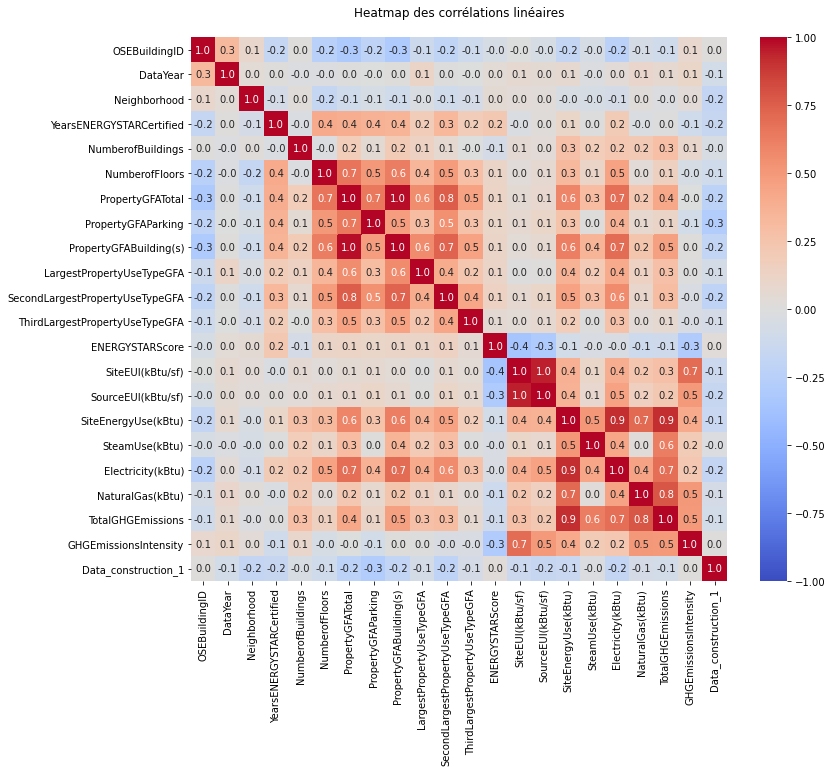

In [226]:
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), annot=True, fmt=".1f", center=0, cmap="coolwarm",vmax=1, vmin=-1)
plt.title(f"Heatmap des corrélations linéaires\n")
plt.savefig('image/corr.png')

In [227]:
threshold = 0.7
corr = data.corr()
corr_pairs = corr.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold)])
               .reset_index().rename(columns={0:'corr_coeff'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('corr_coeff', ascending=False)



,level_0,level_1,corr_coeff
16,PropertyGFABuilding(s),PropertyGFATotal,0.979363
14,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),0.952844
12,TotalGHGEmissions,SiteEnergyUse(kBtu),0.915790
10,SiteEnergyUse(kBtu),Electricity(kBtu),0.915557
8,TotalGHGEmissions,NaturalGas(kBtu),0.787073
6,SecondLargestPropertyUseTypeGFA,PropertyGFATotal,0.763825
4,SecondLargestPropertyUseTypeGFA,PropertyGFABuilding(s),0.736528
2,SiteEnergyUse(kBtu),NaturalGas(kBtu),0.717501
0,SiteEUI(kBtu/sf),GHGEmissionsIntensity,0.700941


In [228]:
# On enleve les colonnes qui sont collinaire avec nos targets
data.drop(columns=['PropertyGFAParking', 'PropertyGFABuilding(s)','SteamUse(kBtu)','SiteEUI(kBtu/sf)','GHGEmissionsIntensity','SourceEUI(kBtu/sf)','Electricity(kBtu)', 'NaturalGas(kBtu)'], inplace=True)

In [229]:
data['Surface_total_GFA'] = data['LargestPropertyUseTypeGFA']+data['SecondLargestPropertyUseTypeGFA']+data['ThirdLargestPropertyUseTypeGFA']
data.drop(columns=['LargestPropertyUseTypeGFA','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA'], inplace=True)

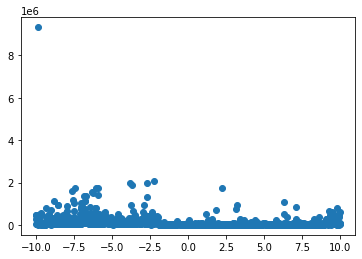

In [230]:
plt.scatter(np.linspace(-10,10,len(data['Surface_total_GFA'])),data['Surface_total_GFA'])

In [231]:
data[data['Surface_total_GFA']>8E6]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,YearsENERGYSTARCertified,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,Data_construction_1,Surface_total_GFA
16,49967,2016,campus,university,10,college/university,pas de piece,pas de piece,0.0,1.0,0.0,83965.369369,NaN,7.873187e+06,100.365405,11.0,9.316884e+06
80,34,2015,sps-district k-12,k-12 school,1,k-12 school,pas de piece,pas de piece,0.0,1.0,1.0,126351.000000,57.0,6.283226e+06,244.510000,6.0,inf
83,37,2015,sps-district k-12,k-12 school,8,k-12 school,pas de piece,pas de piece,0.0,1.0,2.0,51582.000000,94.0,1.484682e+06,10.350000,2.0,inf
131,118,2015,sps-district k-12,k-12 school,2,k-12 school,pas de piece,pas de piece,0.0,1.0,3.0,74468.000000,85.0,1.857329e+06,18.520000,1.0,inf
135,122,2015,sps-district k-12,k-12 school,12,k-12 school,pas de piece,pas de piece,0.0,1.0,2.0,58933.000000,71.0,2.248629e+06,15.675000,2.0,inf
145,140,2015,sps-district k-12,k-12 school,7,k-12 school,pas de piece,pas de piece,0.0,1.0,3.0,66588.000000,75.0,2.068680e+06,14.420000,2.0,inf
182,217,2015,sps-district k-12,k-12 school,0,k-12 school,pas de piece,pas de piece,0.0,1.0,1.0,160270.000000,79.0,5.674450e+06,220.700000,5.0,inf
188,227,2015,sps-district k-12,k-12 school,1,k-12 school,pas de piece,pas de piece,0.0,1.0,3.0,136188.000000,67.0,5.436057e+06,174.700000,5.0,inf
201,242,2015,sps-district k-12,k-12 school,9,k-12 school,pas de piece,pas de piece,0.0,1.0,2.0,52792.000000,98.0,1.227316e+06,8.560000,2.0,inf
658,820,2015,sps-district k-12,k-12 school,1,k-12 school,pas de piece,pas de piece,0.0,1.0,1.0,52924.000000,81.0,1.932482e+06,13.470000,2.0,inf


In [232]:
data.drop(index=16, inplace=True)

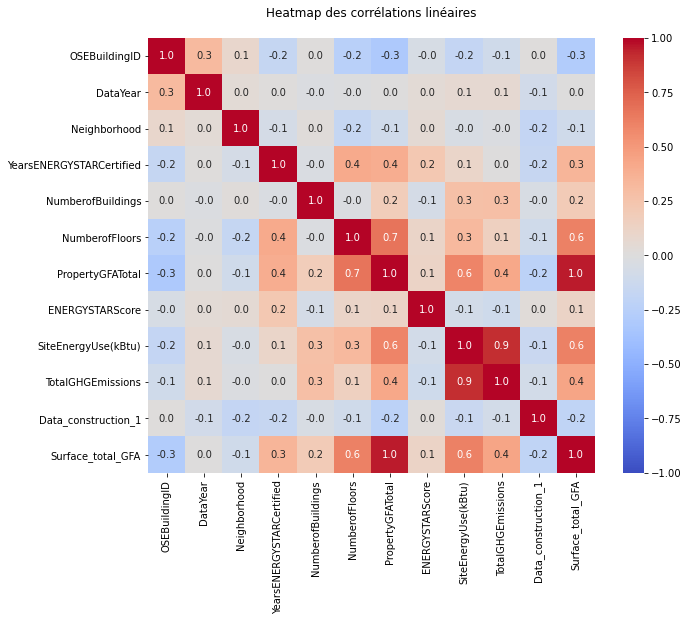

In [233]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, fmt=".1f", center=0, cmap="coolwarm",vmax=1, vmin=-1)
plt.title(f"Heatmap des corrélations linéaires\n")
plt.show()

### Analyse des variables à prédire

In [234]:
# l'hypothèse de Shapiro de normalité des distributions de ces variables pour 'SiteEnergyUse(kBtu)'. p<0.05- rejeté 
res_energie = shapiro(data['SiteEnergyUse(kBtu)'])
res_energie

ShapiroResult(statistic=0.29237693548202515, pvalue=0.0)

<AxesSubplot:ylabel='Frequency'>

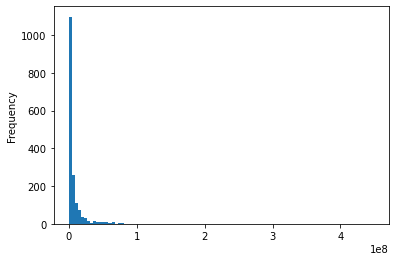

In [235]:
(data['SiteEnergyUse(kBtu)']).plot.hist(bins=100)

In [236]:
# l'hypothèse de Shapiro de normalité des distributions de ces variables pour 'TotalGHGEmissions'. p<0.05- encore rejeté TotalGHGEmissions
res_CO2 = shapiro(data['TotalGHGEmissions'])
res_CO2

ShapiroResult(statistic=0.18352043628692627, pvalue=0.0)

<AxesSubplot:ylabel='Frequency'>

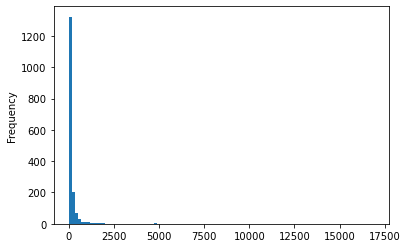

In [237]:
(data['TotalGHGEmissions']).plot.hist(bins=100)

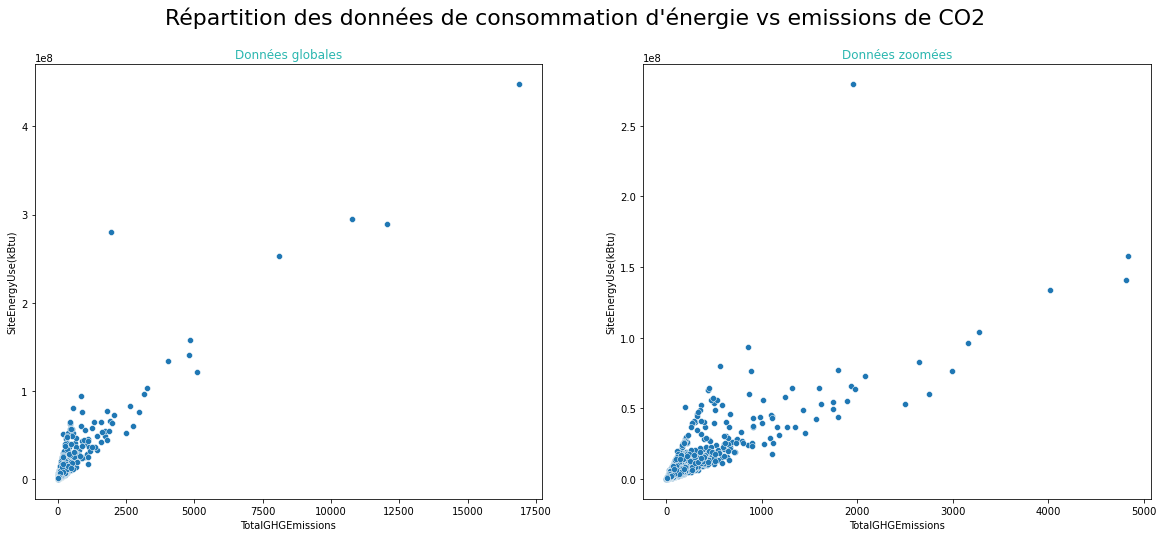

In [238]:
# Projettons à présent les scatterplots des distribition de ces 2 variables entre elles :

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.scatterplot(data=data, x="TotalGHGEmissions", y="SiteEnergyUse(kBtu)", ax=axes[0])
axes[0].set_title("Données globales", color='#2cb7b0')
sns.scatterplot(data=data[(data['TotalGHGEmissions'] < 5000)], x="TotalGHGEmissions", y="SiteEnergyUse(kBtu)", ax=axes[1])
axes[1].set_title("Données zoomées", color='#2cb7b0')
plt.suptitle("Répartition des données de consommation d'énergie vs emissions de CO2", fontsize=22)
plt.show()

### Nous allons à présent regarder la répartition de ces 2 variables en fonction du type de bâtiement.

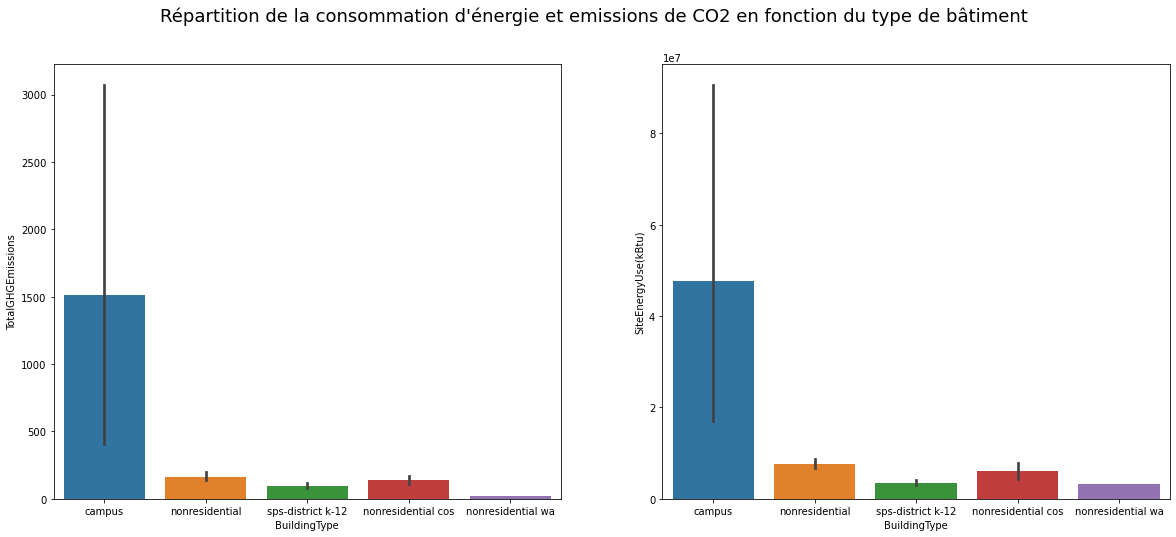

In [239]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.barplot(x='BuildingType',y='TotalGHGEmissions',data=data, ax=axes[0])
sns.barplot(x='BuildingType',y='SiteEnergyUse(kBtu)',data=data, ax=axes[1])
plt.suptitle("Répartition de la consommation d'énergie et emissions de CO2 en fonction du type de bâtiment", 
              fontsize=18)
plt.savefig('energie_vs_CO2')

### Nous allons à présent regarder la répartition de ces 2 variables en fonction de l'age de bâtiement.

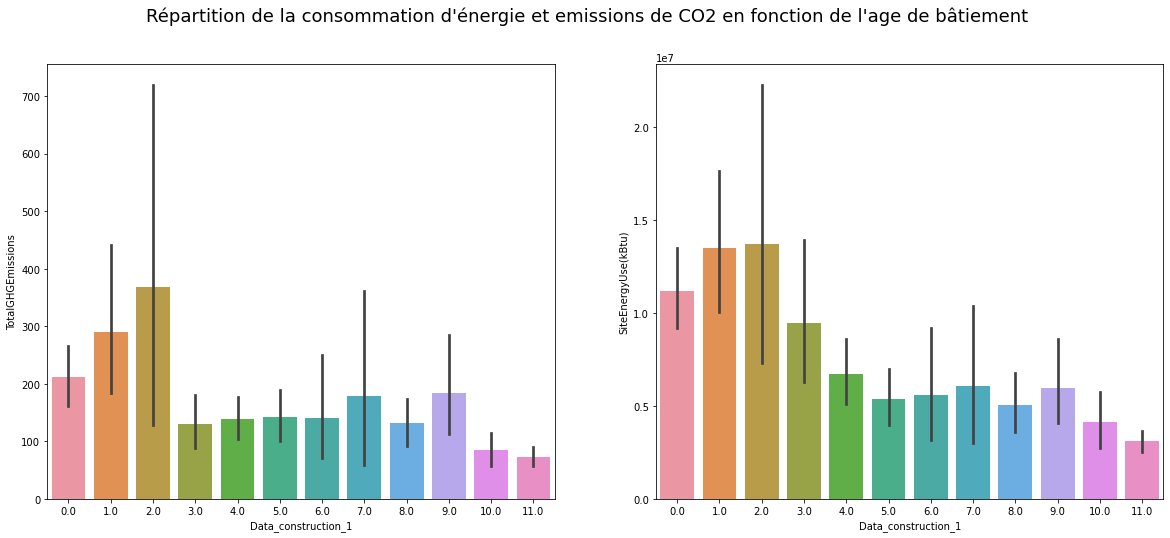

In [240]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.barplot(x='Data_construction_1',y='TotalGHGEmissions',data=data, ax=axes[0])
sns.barplot(x='Data_construction_1',y='SiteEnergyUse(kBtu)',data=data, ax=axes[1])
plt.suptitle("Répartition de la consommation d'énergie et emissions de CO2 en fonction de l'age de bâtiement", 
              fontsize=18)
plt.savefig('en_CO2_age')

In [241]:
data.shape

(1693, 17)

In [242]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1693 entries, 0 to 1696
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   OSEBuildingID                 1693 non-null   int64  
 1   DataYear                      1693 non-null   int64  
 2   BuildingType                  1693 non-null   object 
 3   PrimaryPropertyType           1693 non-null   object 
 4   Neighborhood                  1693 non-null   int8   
 5   LargestPropertyUseType        1693 non-null   object 
 6   SecondLargestPropertyUseType  1693 non-null   object 
 7   ThirdLargestPropertyUseType   1693 non-null   object 
 8   YearsENERGYSTARCertified      1693 non-null   float64
 9   NumberofBuildings             1693 non-null   float64
 10  NumberofFloors                1693 non-null   float64
 11  PropertyGFATotal              1693 non-null   float64
 12  ENERGYSTARScore               1154 non-null   float64
 13  Sit

In [243]:
# Dans le dataset il y des valeurs trop grandes pour dtype('float64')
data['Surface_total_GFA'].describe()

count    1.693000e+03
mean     inf         
std     NaN          
min      8.221738e+03
25%      3.255004e+04
50%      5.296670e+04
75%      1.135377e+05
max      inf         
Name: Surface_total_GFA, dtype: float64

In [244]:
data['Surface_total_GFA'] = data['Surface_total_GFA'].replace([np.inf, -np.inf], np.nan)

In [245]:
data[data['Surface_total_GFA'].isna()].index

Int64Index([80, 83, 131, 135, 145, 182, 188, 201, 658, 674, 725, 996, 1171,
            1656],
           dtype='int64')

In [246]:
# On va attribuer les valeurs de la colonne 'PropertyGFATotal'
for ind in data[data['Surface_total_GFA'].isna()].index:
    data.loc[ind,'Surface_total_GFA'] = data.loc[ind,'PropertyGFATotal']

### Isolation Forest

In [247]:
model_isol = IsolationForest(contamination=0.005) # Isolation des outliers

In [248]:
num_data = data.select_dtypes('float64').columns # récupération des colonnes numériques 
num_data

Index(['YearsENERGYSTARCertified', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)',
       'TotalGHGEmissions', 'Data_construction_1', 'Surface_total_GFA'],
      dtype='object')

In [249]:
num_isol = ['NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 
       'Data_construction_1','Surface_total_GFA']

In [250]:
model_isol.fit(data[num_isol])

IsolationForest(contamination=0.005)

In [251]:
outliers = model_isol.predict(data[num_isol]) == -1
outliers

array([False, False, False, ..., False, False, False])

In [252]:
data[outliers].T

,218,279,315,318,337,523,535,621,661
OSEBuildingID,276,357,399,402,422,640,659,775,828
DataYear,2015,2015,2015,2015,2015,2015,2015,2015,2015
BuildingType,nonresidential,nonresidential cos,nonresidential,nonresidential,nonresidential,nonresidential,nonresidential,nonresidential,nonresidential
PrimaryPropertyType,hospital,large office,large office,large office,large office,large office,large office,large office,hospital
Neighborhood,5,4,4,4,4,6,4,4,5
LargestPropertyUseType,hospital (general medical & surgical),office,office,office,office,office,office,office,hospital (general medical & surgical)
SecondLargestPropertyUseType,parking,parking,parking,parking,parking,retail store,parking,parking,parking
ThirdLargestPropertyUseType,pas de piece,other,other,other,other,non-refrigerated warehouse,financial office,pas de piece,pas de piece
YearsENERGYSTARCertified,0,7.5,7.5,10,5,0,10,10,0
NumberofBuildings,5,1,1,1,1,1,1,1,4


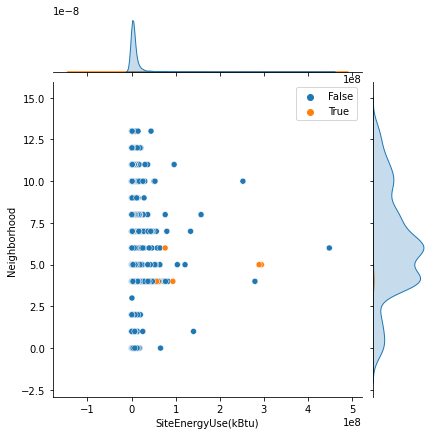

In [253]:
sns.jointplot(x=data["SiteEnergyUse(kBtu)"], y = data["Neighborhood"], hue=outliers)
plt.savefig('image/pict7.png')

In [254]:
# Même si on va standardisé les données, les valeurs atypique peuvent nous empêcher au moment de modélisation 
data.drop(index=[660,217], inplace=True)

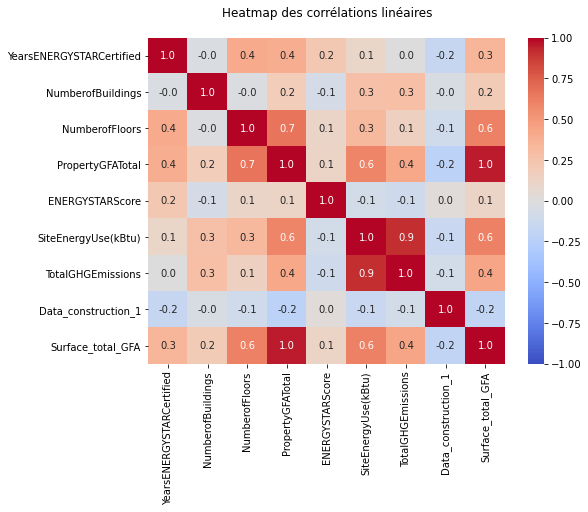

In [255]:
plt.figure(figsize=(8,6))
sns.heatmap(data.select_dtypes('float').corr(), annot=True, fmt=".1f", center=0, cmap="coolwarm",vmax=1, vmin=-1)
plt.title(f"Heatmap des corrélations linéaires\n")
plt.show()

In [256]:
data.drop(columns=['PropertyGFATotal', 'DataYear'],inplace=True)

# PCA

In [257]:
# Observons nos données en 2-d
std = StandardScaler()

In [258]:
X_norm=std.fit_transform(data.select_dtypes('float'))

In [259]:
X_norm = pd.DataFrame(data=X_norm,columns=data.select_dtypes('float').columns)


In [260]:
X_norm.dropna(inplace=True)

In [261]:
pca=PCA(n_components=2)

In [262]:
pca.fit(X_norm)

PCA(n_components=2)

In [263]:
pca.explained_variance_ratio_ # avec 2 colognes on est capable d'expliquer environ 63% de features

array([0.40213508, 0.23029915])

In [264]:
pca_projection = pca.transform(X_norm)

In [265]:
pca_projection.shape

(1152, 2)

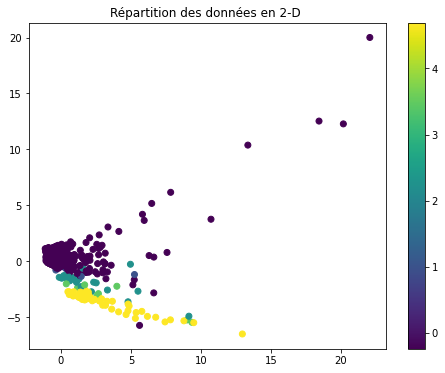

In [266]:
plt.figure(figsize=(8,6))
plt.scatter(pca_projection[:,0],pca_projection[:,1], c=X_norm.get('YearsENERGYSTARCertified'))
plt.title('Répartition des données en 2-D ')
plt.colorbar()
plt.savefig('image/ENERGY_pca.png')

In [267]:
pcs = pca.components_

*  Nous avons des features qui ont une corrélation assez forte (nombre de bâtiments et consommation d'énergie, ..)
*  Anticolinéarité (data constrouction et nombre d'étages, ...)
*  Pas de colinéarité (scores Energy Star et émissions de CO2)

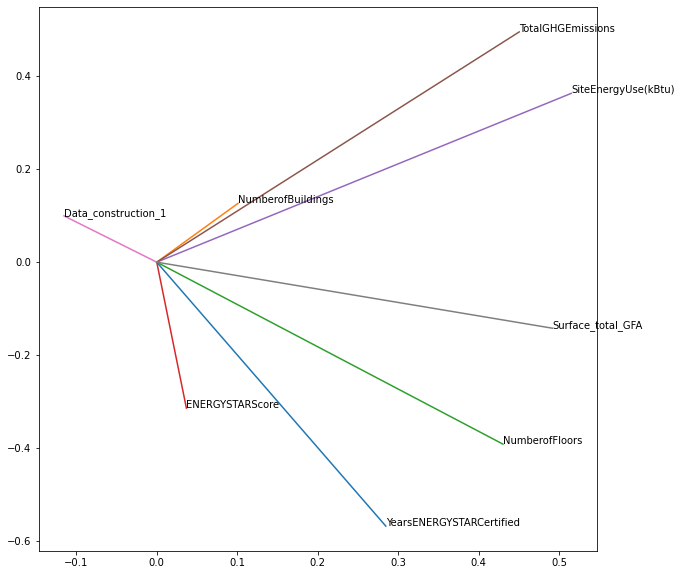

In [268]:
plt.figure(figsize=(10,10))
for i , (n,m) in enumerate(zip(pcs[0,:],pcs[1,:])):
    plt.plot([0,n],[0,m])
    plt.text(n,m,X_norm.columns[i])
plt.savefig('image/corr_star.png')    

In [269]:
data.set_index("OSEBuildingID").to_csv("nettoyage_de_donnees.csv")